# Autotalker Data Analysis Mouse Organogenesis Imputed

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 22.01.2023
- **Date of Last Modification:** 14.02.2023

## 1. Setup

### 1.1 Import Libraries

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import sys
sys.path.append("../../autotalker")

In [7]:
import argparse
import os
import random
import warnings
from datetime import datetime

import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import seaborn as sns
import squidpy as sq
import torch
from matplotlib import gridspec
from matplotlib.pyplot import rc_context

from autotalker.models import Autotalker
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions,
                              filter_and_combine_gp_dict_gps,
                              get_unique_genes_from_gp_dict)

### 1.2 Define Parameters

In [44]:
## Dataset
dataset = "seqfish_mouse_organogenesis"
batch1 = "embryo1_z2"
batch2 = "embryo1_z5"
batch3 = "embryo2_z2"
batch4 = "embryo2_z5"
batch5 = "embryo3_z2"
batch6 = "embryo3_z5"

## Model
# AnnData Keys
counts_key = "log_normalized_counts" # raw counts not available
cell_type_key = "celltype_mapped_refined"
sub_cell_type_key = "sub_cell_type"
adj_key = "spatial_connectivities"
spatial_key = "spatial"
gp_names_key = "autotalker_gp_names"
active_gp_names_key = "autotalker_active_gp_names"
gp_targets_mask_key = "autotalker_gp_targets"
gp_sources_mask_key = "autotalker_gp_sources"
latent_key = "autotalker_latent"
condition_key = "batch"
sample_key = "sample"
query_enriched_cell_type_key = "autotalker_query_enriched_cell_types"
query_enriched_latent_cluster_key = "autotalker_query_enriched_latent_clusters"
mapping_entity_key = "mapping_entity"

# Benchmarking
spatial_knng_key = "autotalker_spatial_knng"
latent_knng_key = "autotalker_latent_knng"

# Analysis
enriched_query_cell_type_prop_thresh = 5
enriched_query_latent_cluster_prop_thresh = 2.5
latent_leiden_resolution = 0.3
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"
denovo_cell_type_differential_gp_scores_key = "autotalker_denovo_cell_type_differential_gp_scores"
cell_type_differential_gp_scores_key = "autotalker_cell_type_differential_gp_scores"
query_enriched_cell_type_differential_gp_scores_key = "autotalker_query_enriched_latent_cluster_differential_gp_scores"
latent_cluster_differential_gp_scores_key = "autotalker_latent_cluster_differential_gp_scores"
query_enriched_latent_cluster_differential_gp_scores_key = "autotalker_query_enriched_latent_cluster_differential_gp_scores"
n_top_up_gps = 3
n_top_down_gps = 3
n_top_genes_per_gp = 3

## Others
random_seed = 42
load_timestamp = "11022023_025252" # "11022023_025252" "10022023_064933" # saved model to be loaded

In [9]:
cell_type_colors = {"Epiblast" : "#635547",
                    "Primitive Streak" : "#DABE99",
                    "Caudal epiblast" : "#9e6762",
                    "PGC" : "#FACB12",
                    "Anterior Primitive Streak" : "#c19f70",
                    "Notochord" : "#0F4A9C",
                    "Def. endoderm" : "#F397C0",
                    "Definitive endoderm" : "#F397C0",
                    "Gut" : "#EF5A9D",
                    "Gut tube" : "#EF5A9D",
                    "Nascent mesoderm" : "#C594BF",
                    "Mixed mesoderm" : "#DFCDE4",
                    "Intermediate mesoderm" : "#139992",
                    "Caudal Mesoderm" : "#3F84AA",
                    "Paraxial mesoderm" : "#8DB5CE",
                    "Somitic mesoderm" : "#005579",
                    "Pharyngeal mesoderm" : "#C9EBFB",
                    "Splanchnic mesoderm" : "#C9EBFB",
                    "Cardiomyocytes" : "#B51D8D",
                    "Allantois" : "#532C8A",
                    "ExE mesoderm" : "#8870ad",
                    "Lateral plate mesoderm" : "#8870ad",
                    "Mesenchyme" : "#cc7818",
                    "Mixed mesenchymal mesoderm" : "#cc7818",
                    "Haematoendothelial progenitors" : "#FBBE92",
                    "Endothelium" : "#ff891c",
                    "Blood progenitors 1" : "#f9decf",
                    "Blood progenitors 2" : "#c9a997",
                    "Erythroid1" : "#C72228",
                    "Erythroid2" : "#f79083",
                    "Erythroid3" : "#EF4E22",
                    "Erythroid" : "#f79083",
                    "Blood progenitors" : "#f9decf",
                    "NMP" : "#8EC792",
                    "Rostral neurectoderm" : "#65A83E",
                    "Caudal neurectoderm" : "#354E23",
                    "Neural crest" : "#C3C388",
                    "Forebrain/Midbrain/Hindbrain" : "#647a4f",
                    "Spinal cord" : "#CDE088",
                    "Surface ectoderm" : "#f7f79e",
                    "Visceral endoderm" : "#F6BFCB",
                    "ExE endoderm" : "#7F6874",
                    "ExE ectoderm" : "#989898",
                    "Parietal endoderm" : "#1A1A1A",
                    "Low quality" : "#e6e6e6",
                    "Cranial mesoderm" : "#77441B",
                    "Anterior somitic tissues" : "#F90026",
                    "Sclerotome" : "#A10037",
                    "Dermomyotome" : "#DA5921",
                    "Posterior somitic tissues" : "#E1C239",
                    "Presomitic mesoderm" : "#9DD84A",
                    "None" : "#D3D3D3"}

In [10]:
latent_cluster_colors = {"0" : "#635547",
                         "1" : "#DABE99",
                         "2" : "#9e6762",
                         "3" : "#FACB12",
                         "4" : "#c19f70",
                         "5" : "#0F4A9C",
                         "6" : "#F397C0",
                         "7" : "#F397C0",
                         "8" : "#EF5A9D",
                         "9" : "#EF5A9D",
                         "10" : "#C594BF",
                         "11" : "#DFCDE4",
                         "12" : "#139992",
                         "13" : "#3F84AA",
                         "14" : "#8DB5CE",
                         "15" : "#005579",
                         "16" : "#C9EBFB",
                         "17" : "#C9EBFB",
                         "18" : "#B51D8D",
                         "19" : "#532C8A",
                         "20" : "#8870ad",
                         "21" : "#8870ad",
                         "22" : "#cc7818",
                         "23" : "#cc7818",
                         "24" : "#FBBE92",
                         "25" : "#ff891c",
                         "26" : "#f9decf",
                         "27" : "#c9a997",
                         "28" : "#C72228",
                         "29" : "#f79083",
                         "30" : "#EF4E22",
                         "31" : "#f79083",
                         "32" : "#f9decf",
                         "33" : "#8EC792",
                         "34" : "#65A83E",
                         "35" : "#354E23",
                         "36" : "#C3C388",
                         "37" : "#647a4f",
                         "38" : "#CDE088",
                         "39" : "#f7f79e",
                         "40" : "#F6BFCB",
                         "41" : "#7F6874",
                         "42" : "#989898",
                         "43" : "#1A1A1A",
                         "44" : "#e6e6e6",
                         "45" : "#77441B",
                         "46" : "#F90026",
                         "47" : "#A10037",
                         "48" : "#DA5921",
                         "49" : "#E1C239",
                         "-1" : "#9DD84A",
                         "None" : "#D3D3D3"}

### 1.3 Run Notebook Setup

In [11]:
sc.set_figure_params(figsize=(6, 6))
sns.set_style("whitegrid", {'axes.grid' : False})

In [12]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

In [13]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
if load_timestamp is not None:
    current_timestamp = load_timestamp
else:
    current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Create Directories

In [14]:
# Define paths
figure_folder_path = f"../figures/{dataset}/analysis/{current_timestamp}"
model_artifacts_folder_path = f"../artifacts/{dataset}/analysis/{current_timestamp}"
gp_data_folder_path = "../datasets/gp_data" # gene program data
srt_data_folder_path = "../datasets/srt_data" # spatially resolved transcriptomics data
srt_data_gold_folder_path = f"{srt_data_folder_path}/gold"
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"

# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(model_artifacts_folder_path, exist_ok=True)

### 1.5 Define Functions

In [65]:
def plot_physical_latent_for_cell_types(adata,
                                        cell_types,
                                        save_fig=False):
    # Create plot of cell type annotations in physical and latent space
    fig = plt.figure(figsize=(12, 14))
    title = fig.suptitle(t=f"{' & '.join(cell_types).title()} in Physical and Latent Space",
                         y=0.96,
                         x=0.55,
                         fontsize=20)
    spec = gridspec.GridSpec(ncols=1,
                             nrows=2,
                             width_ratios=[1],
                             height_ratios=[1, 5])
    ax1 = fig.add_subplot(2, 3, 1)
    ax2 = fig.add_subplot(2, 3, 2)
    ax3 = fig.add_subplot(2, 3, 3)
    ax4 = fig.add_subplot(spec[1])
    sc.pl.spatial(adata=adata[adata.obs[sample_key] == "embryo1"],
                  color=[cell_type_key],
                  palette=cell_type_colors,
                  groups=cell_types,
                  size=160000/len(model.adata),
                  spot_size=0.03,
                  title="Physical Space Embryo 1",
                  legend_loc=None,
                  ax=ax1,
                  show=False)
    sc.pl.spatial(adata=adata[adata.obs[sample_key] == "embryo2"],
                  color=[cell_type_key],
                  palette=cell_type_colors,
                  groups=cell_types,
                  size=160000/len(model.adata),
                  spot_size=0.03,
                  title="Physical Space Embryo 2",
                  legend_loc=None,
                  ax=ax2,
                  show=False)
    sc.pl.spatial(adata=adata[adata.obs[sample_key] == "embryo3"],
                  color=[cell_type_key],
                  palette=cell_type_colors,
                  groups=cell_types,
                  size=160000/len(model.adata),
                  spot_size=0.03,
                  title="Physical Space Embryo 3",
                  legend_loc=None,
                  ax=ax3,
                  show=False)
    sc.pl.umap(adata=adata,
               color=[cell_type_key],
               palette=cell_type_colors,
               groups=cell_types,
               size=1280000/len(model.adata),
               title="Autotalker Latent Space",
               ax=ax4,
               show=False)

    # Create and position shared legend
    handles, labels = ax4.get_legend_handles_labels()
    lgd = fig.legend(handles, labels, bbox_to_anchor=(1.12, 0.655))
    ax4.get_legend().remove()

    # Adjust, save and display plot
    plt.subplots_adjust(wspace=0., hspace=0.85)
    if save_fig:
        fig.savefig(f"{figure_folder_path}/"
                    f"{'_'.join(cell_types).replace('/', '_').replace(' ', '_').lower()}_physical_latent_space.png",
                    bbox_extra_artists=(lgd, title),
                    bbox_inches="tight")
    plt.show()

In [81]:
def plot_latent_physical_for_cell_type_latent_clusters(adata,
                                                       cell_type,
                                                       save_fig=False):
    # Create plot of cell type annotations in physical and latent space
    fig = plt.figure(figsize=(12, 14))
    title = fig.suptitle(t=f"{cell_type.replace('_', ' ').title()} Latent Clusters in Latent and Physical Space",
                         y=0.96,
                         x=0.55,
                         fontsize=20)
    spec1 = gridspec.GridSpec(ncols=1,
                              nrows=2,
                              width_ratios=[1],
                              height_ratios=[3, 2])
    spec2 = gridspec.GridSpec(ncols=3,
                              nrows=2,
                              width_ratios=[1, 1, 1],
                              height_ratios=[3, 2])
    ax1 = fig.add_subplot(spec1[0])
    ax2 = fig.add_subplot(spec2[3])
    ax3 = fig.add_subplot(spec2[4])
    ax4 = fig.add_subplot(spec2[5])
    sc.pl.umap(adata=adata,
               color=[cell_type_latent_cluster_key],
               palette=latent_cluster_colors,
               size=1280000/len(model.adata),
               title=f"{cell_type.replace('_', ' ').title()} Latent Clusters in Latent Space",
               ax=ax1,
               show=False)
    sc.pl.spatial(adata=adata[model.adata.obs[sample_key] == "embryo1"],
                  color=[cell_type_latent_cluster_key],
                  palette=latent_cluster_colors,
                  size=160000/len(model.adata),
                  spot_size=0.03,
                  title=f"{cell_type.replace('_', ' ').title()} \n Latent Clusters in \n Physical Space Embryo 1",
                  legend_loc=None,
                  ax=ax2,
                  show=False)
    sc.pl.spatial(adata=adata[model.adata.obs[sample_key] == "embryo2"],
                  color=[cell_type_latent_cluster_key],
                  palette=latent_cluster_colors,
                  size=160000/len(model.adata),
                  spot_size=0.03,
                  title=f"{cell_type.replace('_', ' ').title()} \n Latent Clusters in \n Physical Space Embryo 2",
                  legend_loc=None,
                  ax=ax3,
                  show=False)
    sc.pl.spatial(adata=adata[model.adata.obs[sample_key] == "embryo3"],
                  color=[cell_type_latent_cluster_key],
                  palette=latent_cluster_colors,
                  size=160000/len(model.adata),
                  spot_size=0.03,
                  title=f"{cell_type.replace('_', ' ').title()} \n Latent Clusters in \n Physical Space Embryo 3",
                  legend_loc=None,
                  ax=ax4,
                  show=False)

    # Create and position shared legend
    handles, labels = ax1.get_legend_handles_labels()
    lgd = fig.legend(handles, labels, bbox_to_anchor=(1.05, 0.5))
    ax1.get_legend().remove()

    # Adjust, save and display plot
    plt.subplots_adjust(wspace=0.2, hspace=0.25)
    if save_fig:
        fig.savefig(f"{figure_folder_path}/{cell_type.replace('/', '_').replace(' ', '_').lower()}_latent_clusters_physical_latent_space.png",
                    bbox_extra_artists=(lgd, title),
                    bbox_inches="tight")
    plt.show()

In [69]:
def get_differential_analysis_results(analysis_label,
                                      model,
                                      adata,
                                      cat_key,
                                      selected_cats,
                                      differential_gp_scores_key,
                                      comparison_cats=None,
                                      selected_gps=None,
                                      n_top_up_gps=3,
                                      n_top_down_gps=3,
                                      feature_spaces=["latent"], # "physical_embryo1", "physical_embryo2", "physical_embryo3"
                                      save_figs=False):
    # Compute gene program enrichments and retrieve top up- and downregulated gene programs
    top_unique_gps = model.compute_differential_gp_scores(cat_key=cat_key,
                                                          adata=adata,
                                                          selected_gps=selected_gps,
                                                          selected_cats=selected_cats,
                                                          gp_scores_weight_normalization=False,
                                                          comparison_cats=comparison_cats,
                                                          n_sample=10000,
                                                          key_added=differential_gp_scores_key,
                                                          n_top_up_gps_retrieved=n_top_up_gps,
                                                          n_top_down_gps_retrieved=n_top_down_gps,
                                                          seed=random_seed)

    # Display top upregulated gene programs
    top_up_gp_df = model.adata.uns[differential_gp_scores_key][:n_top_up_gps]
    display(top_up_gp_df)

    # Display top downregulated gene programs
    top_down_gp_df = model.adata.uns[differential_gp_scores_key][-n_top_down_gps:][::-1]
    display(top_down_gp_df)

    fig = sc.pl.dotplot(model.adata,
                        top_unique_gps,
                        groupby=cat_key,
                        dendrogram=True, 
                        title=f"{analysis_label.replace('_', ' ').title()} Differential GP Scores",
                        swap_axes=True,
                        return_fig=True)
    # Save and display plot
    if save_figs:
        fig.savefig(f"{figure_folder_path}/{analysis_label}_differential_gp_scores.png")
        plt.show()

    # Inspect top up- and downregulated gene programs
    display(gp_summary_df[gp_summary_df["gp_name"].isin(top_unique_gps)])

    top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
    top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()

    top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
    top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()

    get_cat_gp_score_gene_expr_summary(analysis_label="mixed_mesenchymal_mesoderm_latent_cluster",
                                       model=model,
                                       cats=top_cats,
                                       gps=top_gps,
                                       cat_key=cat_key,
                                       adata=adata,
                                       feature_spaces=feature_spaces,
                                       plot_types=["gene_categories", "individual_genes"])

In [15]:
def get_cat_gp_score_gene_expr_summary(analysis_label,
                                       model,
                                       cats,
                                       gps,
                                       cat_key,
                                       adata=None,
                                       feature_spaces=["latent", "physical_embryo1", "physical_embryo2", "physical_embryo3"],
                                       plot_types=["gene_categories", "individual_genes"],
                                       n_top_genes_per_gp=5,
                                       save_figs=False):
    
    if adata is None:
        adata = model.adata.copy()
    
    for gp in gps:
        gp_gene_importances_df = model.compute_gp_gene_importances(selected_gp=gp)
        
        pos_sign_target_genes = gp_gene_importances_df.loc[
            (gp_gene_importances_df["gene_weight_sign_corrected"] > 0) &
            (gp_gene_importances_df["gene_entity"] == "target"), "gene"].tolist()
        pos_sign_source_genes = gp_gene_importances_df.loc[
            (gp_gene_importances_df["gene_weight_sign_corrected"] > 0) &
            (gp_gene_importances_df["gene_entity"] == "source"), "gene"].tolist()
        neg_sign_target_genes = gp_gene_importances_df.loc[
            (gp_gene_importances_df["gene_weight_sign_corrected"] < 0) &
            (gp_gene_importances_df["gene_entity"] == "target"), "gene"].tolist()
        neg_sign_source_genes = gp_gene_importances_df.loc[
            (gp_gene_importances_df["gene_weight_sign_corrected"] < 0) &
            (gp_gene_importances_df["gene_entity"] == "source"), "gene"].tolist()
        
        pos_sign_target_gene_importances = gp_gene_importances_df.loc[
            (gp_gene_importances_df["gene_weight_sign_corrected"] > 0) &
            (gp_gene_importances_df["gene_entity"] == "target"), "gene_importance"].values.reshape(1, -1)
        pos_sign_source_gene_importances = gp_gene_importances_df.loc[
            (gp_gene_importances_df["gene_weight_sign_corrected"] > 0) &
            (gp_gene_importances_df["gene_entity"] == "source"), "gene_importance"].values.reshape(1, -1)
        neg_sign_target_gene_importances = gp_gene_importances_df.loc[
            (gp_gene_importances_df["gene_weight_sign_corrected"] < 0) &
            (gp_gene_importances_df["gene_entity"] == "target"), "gene_importance"].values.reshape(1, -1)
        neg_sign_source_gene_importances = gp_gene_importances_df.loc[
            (gp_gene_importances_df["gene_weight_sign_corrected"] < 0) &
            (gp_gene_importances_df["gene_entity"] == "source"), "gene_importance"].values.reshape(1, -1)
        
        pos_sign_target_gene_expr = adata[:, pos_sign_target_genes].X.toarray()
        pos_sign_source_gene_expr = adata[:, pos_sign_source_genes].X.toarray()
        neg_sign_target_gene_expr = adata[:, neg_sign_target_genes].X.toarray()
        neg_sign_source_gene_expr = adata[:, neg_sign_source_genes].X.toarray()
        
        adata.obs[f"{gp}_pos_sign_target_gene_weighted_mean_gene_expr"] = (
            np.mean(pos_sign_target_gene_expr * pos_sign_target_gene_importances, axis=1))
        adata.obs[f"{gp}_pos_sign_source_gene_weighted_mean_gene_expr"] = (
            np.mean(pos_sign_source_gene_expr * pos_sign_source_gene_importances, axis=1))
        adata.obs[f"{gp}_neg_sign_target_gene_weighted_mean_gene_expr"] = (
            np.mean(neg_sign_target_gene_expr * neg_sign_target_gene_importances, axis=1))
        adata.obs[f"{gp}_neg_sign_source_gene_weighted_mean_gene_expr"] = (
            np.mean(neg_sign_source_gene_expr * neg_sign_source_gene_importances, axis=1))
        
        adata.uns[f"{gp}_gene_category_importances"] = np.array([pos_sign_target_gene_importances.sum(),
                                                                 pos_sign_source_gene_importances.sum(),
                                                                 neg_sign_target_gene_importances.sum(),
                                                                 neg_sign_source_gene_importances.sum()])
        
        adata.uns["n_top_genes"] = n_top_genes_per_gp
        adata.uns[f"{gp}_top_genes"] = gp_gene_importances_df["gene"][:n_top_genes_per_gp]
        adata.uns[f"{gp}_top_gene_importances"] = gp_gene_importances_df["gene_importance"][:n_top_genes_per_gp]
        adata.uns[f"{gp}_top_gene_signs"] = np.where(gp_gene_importances_df["gene_weight_sign_corrected"] > 0, "+", "-")
        adata.uns[f"{gp}_top_gene_entities"] = gp_gene_importances_df["gene_entity"]
        
    for feature_space in feature_spaces:
        for plot_type in plot_types:
            plot_cat_gp_score_gene_expr_summary(adata=adata,
                                                cats=cats,
                                                gps=gps,
                                                plot_type=plot_type,
                                                plot_category=cat_key,
                                                feature_space=feature_space,
                                                suptitle=f"{analysis_label.replace('_', ' ').title()} Differential GPs: "
                                                         f"GP Scores and {'Weighted Mean ' if plot_type == 'gene_categories' else ''}"
                                                         f"Gene Expression of {plot_type.replace('_', ' ').title()} in {feature_space.replace('_', ' ').title()} Space",
                                                cat_title=f"GP-enriched \n {analysis_label.replace('_', ' ')}",
                                                save_fig=save_figs,
                                                fig_name=f"{analysis_label}_gp_scores_{'weighted_mean_' if plot_type == 'gene_categories' else ''}gene_expr_"
                                                         f"{analysis_label}_{feature_space}_space")

In [16]:
def plot_cat_gp_score_gene_expr_summary(adata,
                                        cats,
                                        gps,
                                        plot_type,
                                        plot_category,
                                        feature_space,
                                        suptitle,
                                        cat_title,
                                        save_fig,
                                        fig_name):
        
    # Plot selected gene program latent scores
    if plot_type == "gene_categories":
        ncols = 6
        fig_width = 36
        wspace = 0.155
    elif plot_type == "individual_genes":
        ncols = 2 + adata.uns["n_top_genes"]
        fig_width = 12 + (6 * adata.uns["n_top_genes"])
        wspace = 0.3
    fig, axs = plt.subplots(nrows=len(gps), ncols=ncols, figsize=(fig_width, 6*len(gps)))
    if axs.ndim == 1:
        axs = axs.reshape(1, -1)

    title = fig.suptitle(t=suptitle,
                         x=0.55,
                         y=(1.1 if len(gps) == 1 else 0.94),
                         fontsize=20)
    for i, gp in enumerate(gps):
        if feature_space == "latent":
            sc.pl.umap(adata,
                       color=plot_category,
                       palette=latent_cluster_colors,
                       groups=[x for x in adata.obs[cell_type_latent_cluster_emphasis_key].unique().tolist() if str(x) != "nan"],
                       ax=axs[i, 0],
                       title=cat_title,
                       legend_loc="on data",
                       na_in_legend=False,
                       show=False)
            sc.pl.umap(adata,
                       color=gps[i],
                       color_map="RdBu",
                       ax=axs[i, 1],
                       title=f"{gp[:gp.index('_')]}\n{gp[gp.index('_') + 1: gp.rindex('_')].replace('_', ' ')}\n{gp[gps[i].rindex('_') + 1:]} score",
                       show=False)
        elif "physical" in feature_space:
            sc.pl.spatial(adata=adata[adata.obs["sample"] == feature_space.split("_")[1]],
                          color=plot_category,
                          palette=latent_cluster_colors,
                          groups=[x for x in adata.obs[cell_type_latent_cluster_emphasis_key].unique().tolist() if str(x) != "nan"],
                          ax=axs[i, 0],
                          spot_size=0.03,
                          title=cat_title,
                          legend_loc="on data",
                          na_in_legend=False,
                          show=False)
            sc.pl.spatial(adata=adata[adata.obs["sample"] == feature_space.split("_")[1]],
                          color=gps[i],
                          color_map="RdBu",
                          spot_size=0.03,
                          title=f"{gps[i].split('_', 1)[0]}\n{gps[i].split('_', 1)[1]}",
                          legend_loc=None,
                          ax=axs[i, 1],
                          show=False) 
        axs[i, 0].xaxis.label.set_visible(False)
        axs[i, 0].yaxis.label.set_visible(False)
        axs[i, 1].xaxis.label.set_visible(False)
        axs[i, 1].yaxis.label.set_visible(False)
        if plot_type == "gene_categories":
            for j, gene_category in enumerate(["pos_sign_target_gene",
                                               "pos_sign_source_gene",
                                               "neg_sign_target_gene",
                                               "neg_sign_source_gene"]):
                if not adata.obs[f"{gp}_{gene_category}_weighted_mean_gene_expr"].isna().any():
                    if feature_space == "latent":
                        sc.pl.umap(adata,
                                   color=f"{gp}_{gene_category}_weighted_mean_gene_expr",
                                   color_map=("Blues" if "pos_sign" in gene_category else "Reds"),
                                   ax=axs[i, j+2],
                                   legend_loc="on data",
                                   na_in_legend=False,
                                   title=f"Weighted mean gene expression \n {gene_category.replace('_', ' ')} ({adata.uns[f'{gp}_gene_category_importances'][j]:.2f})",
                                   show=False)
                    elif "physical" in feature_space:
                        sc.pl.spatial(adata=adata[adata.obs["sample"] == feature_space.split("_")[1]],
                                      color=f"{gp}_{gene_category}_weighted_mean_gene_expr",
                                      color_map=("Blues" if "pos_sign" in gene_category else "Reds"),
                                      ax=axs[i, 2+j],
                                      legend_loc="on data",
                                      na_in_legend=False,
                                      groups=cats[i],
                                      spot_size=0.03,
                                      title=f"Weighted mean gene expression \n {gene_category.replace('_', ' ')} ({adata.uns[f'{gp}_gene_category_importances'][j]:.2f})",
                                      show=False)                        
                    axs[i, j+2].xaxis.label.set_visible(False)
                    axs[i, j+2].yaxis.label.set_visible(False)
                else:
                    axs[i, j+2].set_visible(False)
        elif plot_type == "individual_genes":
            for j in range(len(adata.uns[f"{gp}_top_genes"])):
                if feature_space == "latent":
                    sc.pl.umap(adata,
                               color=adata.uns[f"{gp}_top_genes"][j],
                               color_map=("Blues" if adata.uns[f"{gp}_top_gene_signs"][j] == "+" else "Reds"),
                               ax=axs[i, 2+j],
                               legend_loc="on data",
                               na_in_legend=False,
                               title=f"{adata.uns[f'{gp}_top_genes'][j]}: {adata.uns[f'{gp}_top_gene_importances'][j]:.2f} ({adata.uns[f'{gp}_top_gene_entities'][j][0]}; {adata.uns[f'{gp}_top_gene_signs'][j]})",
                               show=False)
                elif "physical" in feature_space:
                    sc.pl.spatial(adata=adata[adata.obs["sample"] == feature_space.split("_")[1]],
                                  color=adata.uns[f"{gp}_top_genes"][j],
                                  color_map=("Blues" if adata.uns[f"{gp}_top_gene_signs"][j] == "+" else "Reds"),
                                  legend_loc="on data",
                                  na_in_legend=False,
                                  ax=axs[i, 2+j],
                                  # groups=cats[i],
                                  spot_size=0.03,
                                  title=f"{adata.uns[f'{gp}_top_genes'][j]}: {adata.uns[f'{gp}_top_gene_importances'][j]:.2f} ({adata.uns[f'{gp}_top_gene_entities'][j][0]}; {adata.uns[f'{gp}_top_gene_signs'][j]})",
                                  show=False)
                axs[i, 2+j].xaxis.label.set_visible(False)
                axs[i, 2+j].yaxis.label.set_visible(False)
            for k in range(len(adata.uns[f"{gp}_top_genes"]), ncols - 2):
                axs[i, 2+k].set_visible(False)            

    # Save and display plot
    plt.subplots_adjust(wspace=wspace, hspace=0.275)
    if save_fig:
        fig.savefig(f"{figure_folder_path}/{fig_name}.png",
                    bbox_extra_artists=(title,),
                    bbox_inches="tight")
    plt.show()

In [17]:
def add_sub_cell_type(row):  
    if row[cell_type_key] == cell_type.replace("_", " ").capitalize():
        return row[cell_type_key] + " cluster " + row[cell_type_latent_cluster_key]
    return row[cell_type_key]

In [18]:
def add_cell_type_latent_cluster_emphasis(row, comparison_latent_clusters):  
    for comparison_latent_cluster in comparison_latent_clusters:
        if row[cell_type_latent_cluster_key] == comparison_latent_cluster:
            return "-1"
    return row[cell_type_latent_cluster_key]

## 2. Analysis

### 2.1 Load Model

In [19]:
if load_timestamp is not None:
    model_artifacts_load_folder_path = f"../artifacts/{dataset}/batch_integration/{load_timestamp}"
else:
    model_artifacts_load_folder_path = model_artifacts_folder_path
    
# Load trained model    
model = Autotalker.load(dir_path=f"{model_artifacts_load_folder_path}/reference_query",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> False
CONDITIONAL EMBEDDING INJECTION -> ['encoder', 'gene_expr_decoder', 'graph_decoder']
GRAPH ENCODER -> n_input: 5214, n_cond_embed_input: 3, n_hidden: 1523, n_latent: 1523, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 3, n_output: 1523, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 1523, n_cond_embed_input: 3, n_addon_input: 0, n_output: 10428


### 2.2 Retrieve GP Summary

In [20]:
# Check number of active gene programs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

Number of total gene programs: 1523.
Number of active gene programs: 266.


In [21]:
gp_summary_df = model.get_gp_summary()

## 3. Dataset-specific Analysis & Validation of Results from Lohoff et. al 2022

### 3.1 Cardiomyocytes & Endothelium

Cardiomyocytes are spatially and morphologically distinct from other cell types, endothelium is interspersed and spread across the entire embryo space.

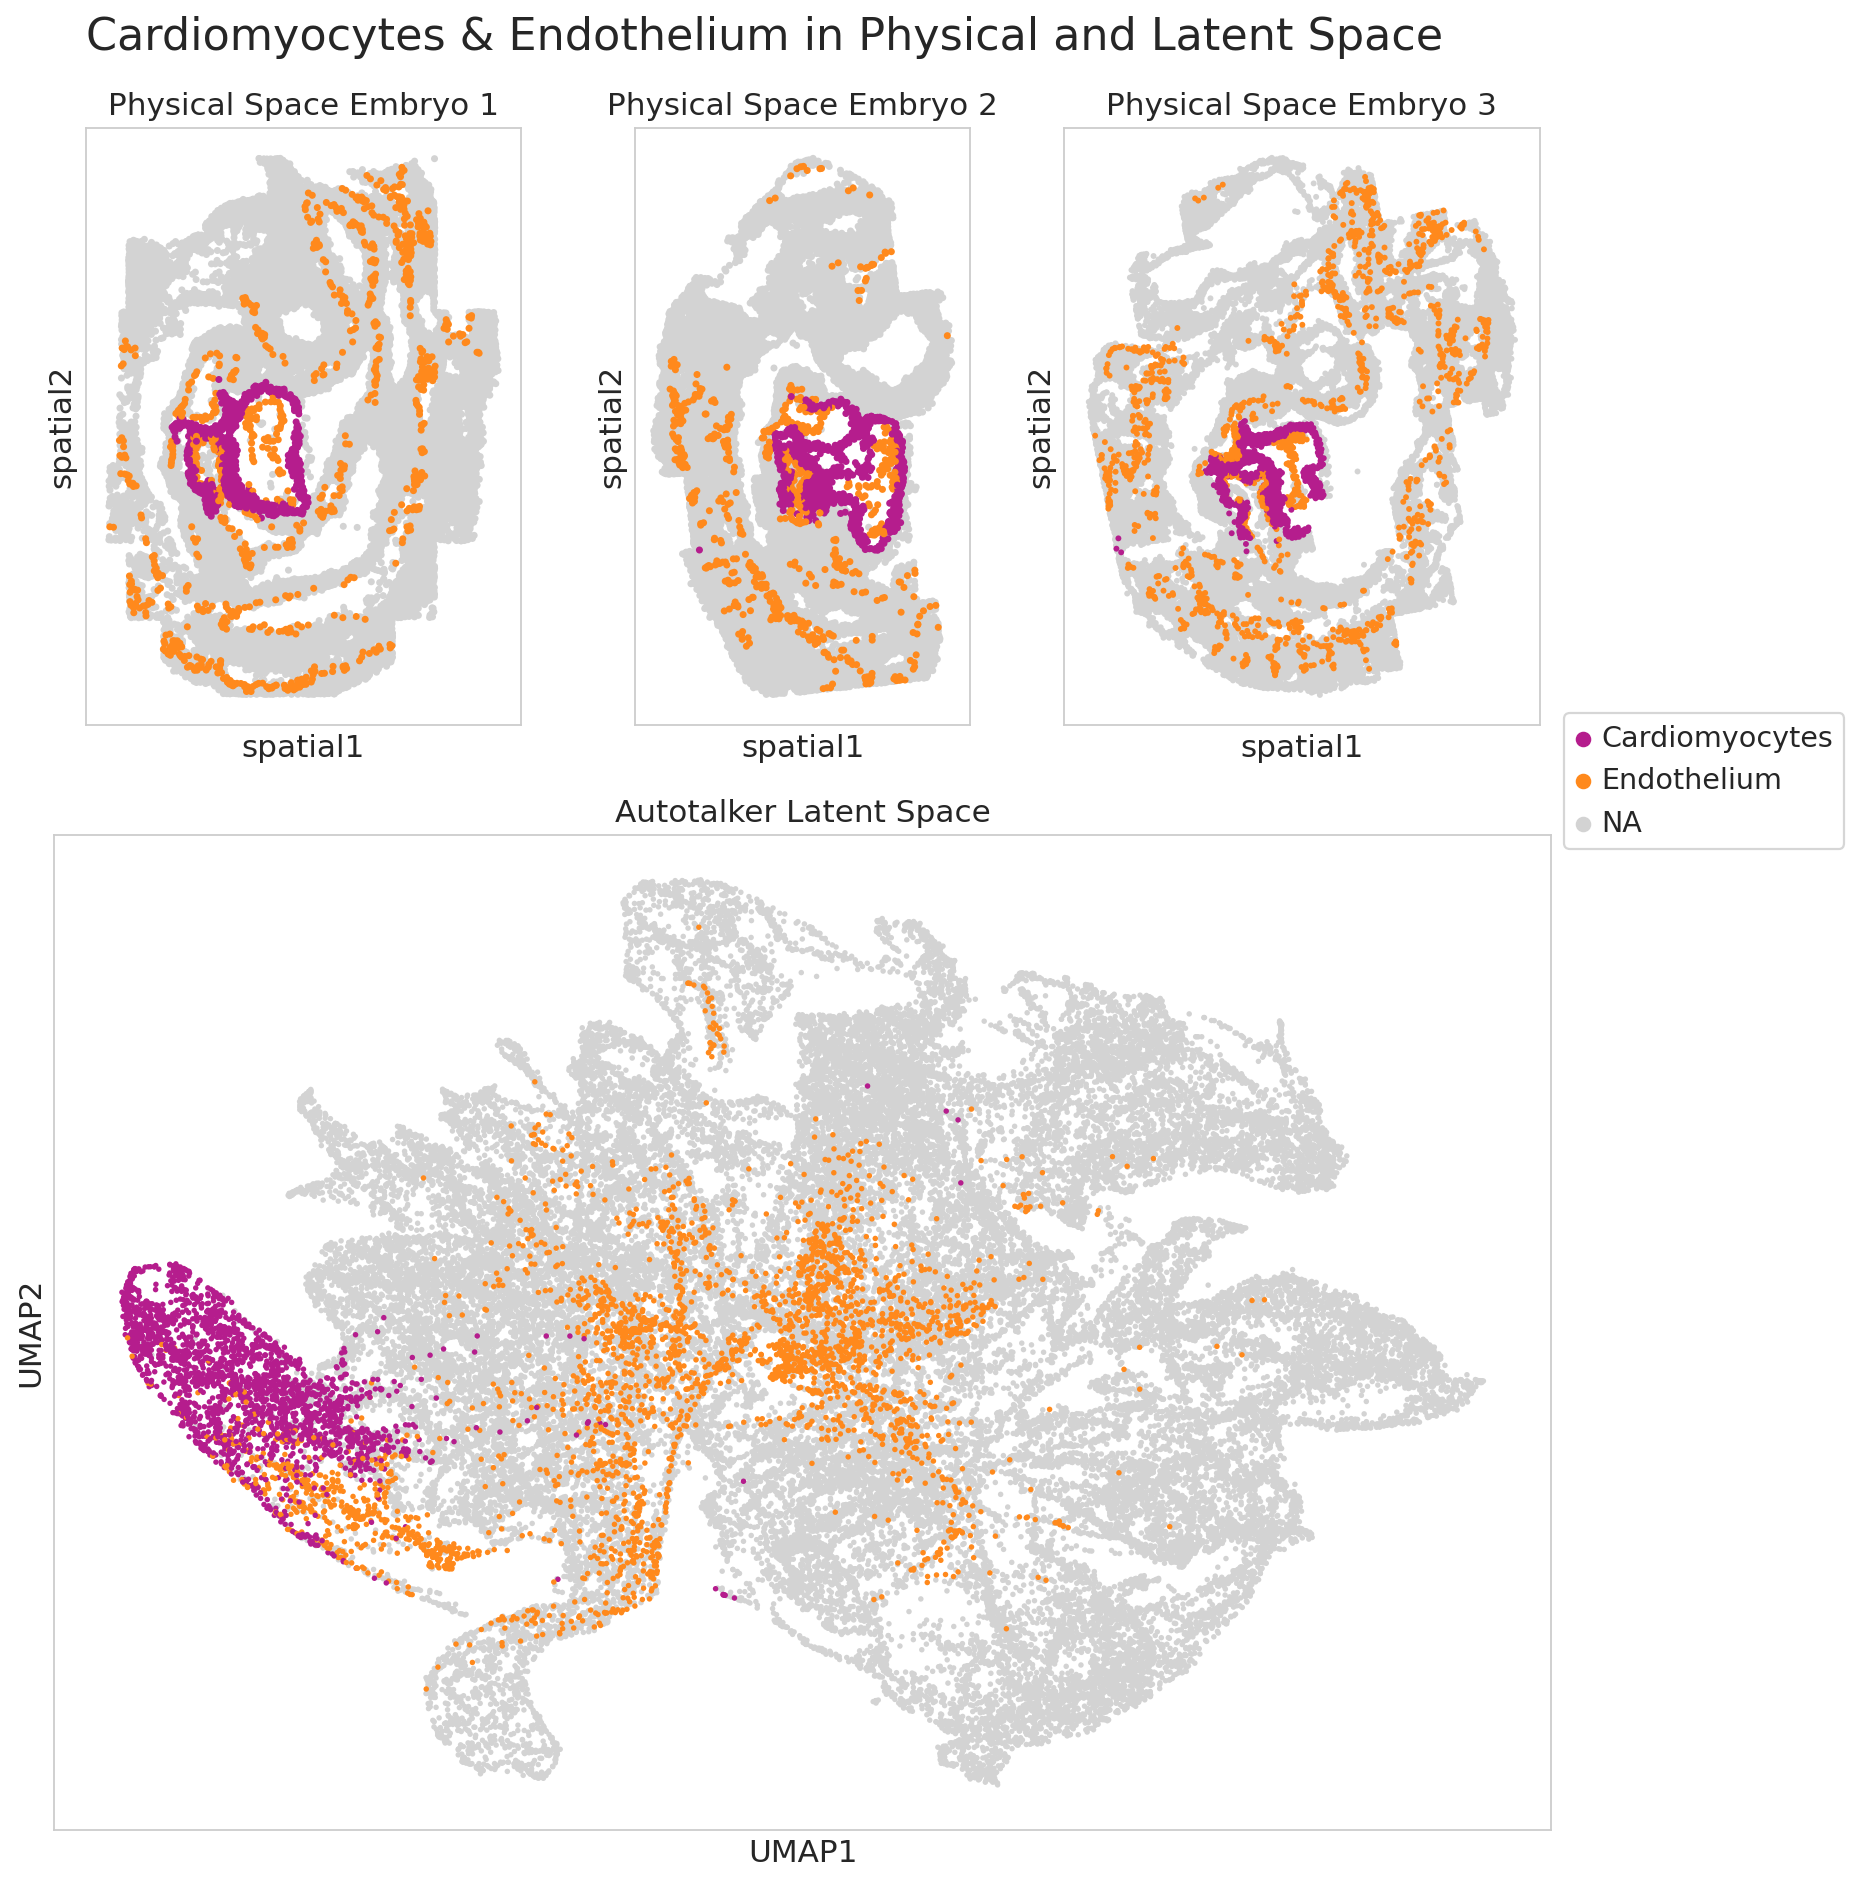

In [68]:
plot_physical_latent_for_cell_types(adata=model.adata,
                                    cell_types=["Cardiomyocytes", "Endothelium"],
                                    save_fig=True)

### 3.2 Mixed Mesenchymal Mesoderm

"mixed mesenchymal mesoderm, represent 
a cell state rather than a defined cell type. Mesenchyme represents  a  state  in  which  cells  express  markers  characteristic  of  migratory   cells loosely dispersed within an extracellular matrix56. This strong  overriding transcriptional signature of mesenchyme, irrespective of  location,  makes  it  challenging  to  distinguish  which  cell  types  this   mixed  mesenchymal  mesoderm  population  represents  using  clas- sical scRNA-seq data"

We can identify distinct subpopulations that are spatially defined.

In [72]:
cell_type = "mixed_mesenchymal_mesoderm"
cell_type_latent_resolution = 0.06 # 0.05
cell_type_latent_cluster_key = f"{cell_type}_latent_leiden_{cell_type_latent_resolution}"
cell_type_differential_gp_scores_key = f"{cell_type}_differential_gp_scores"

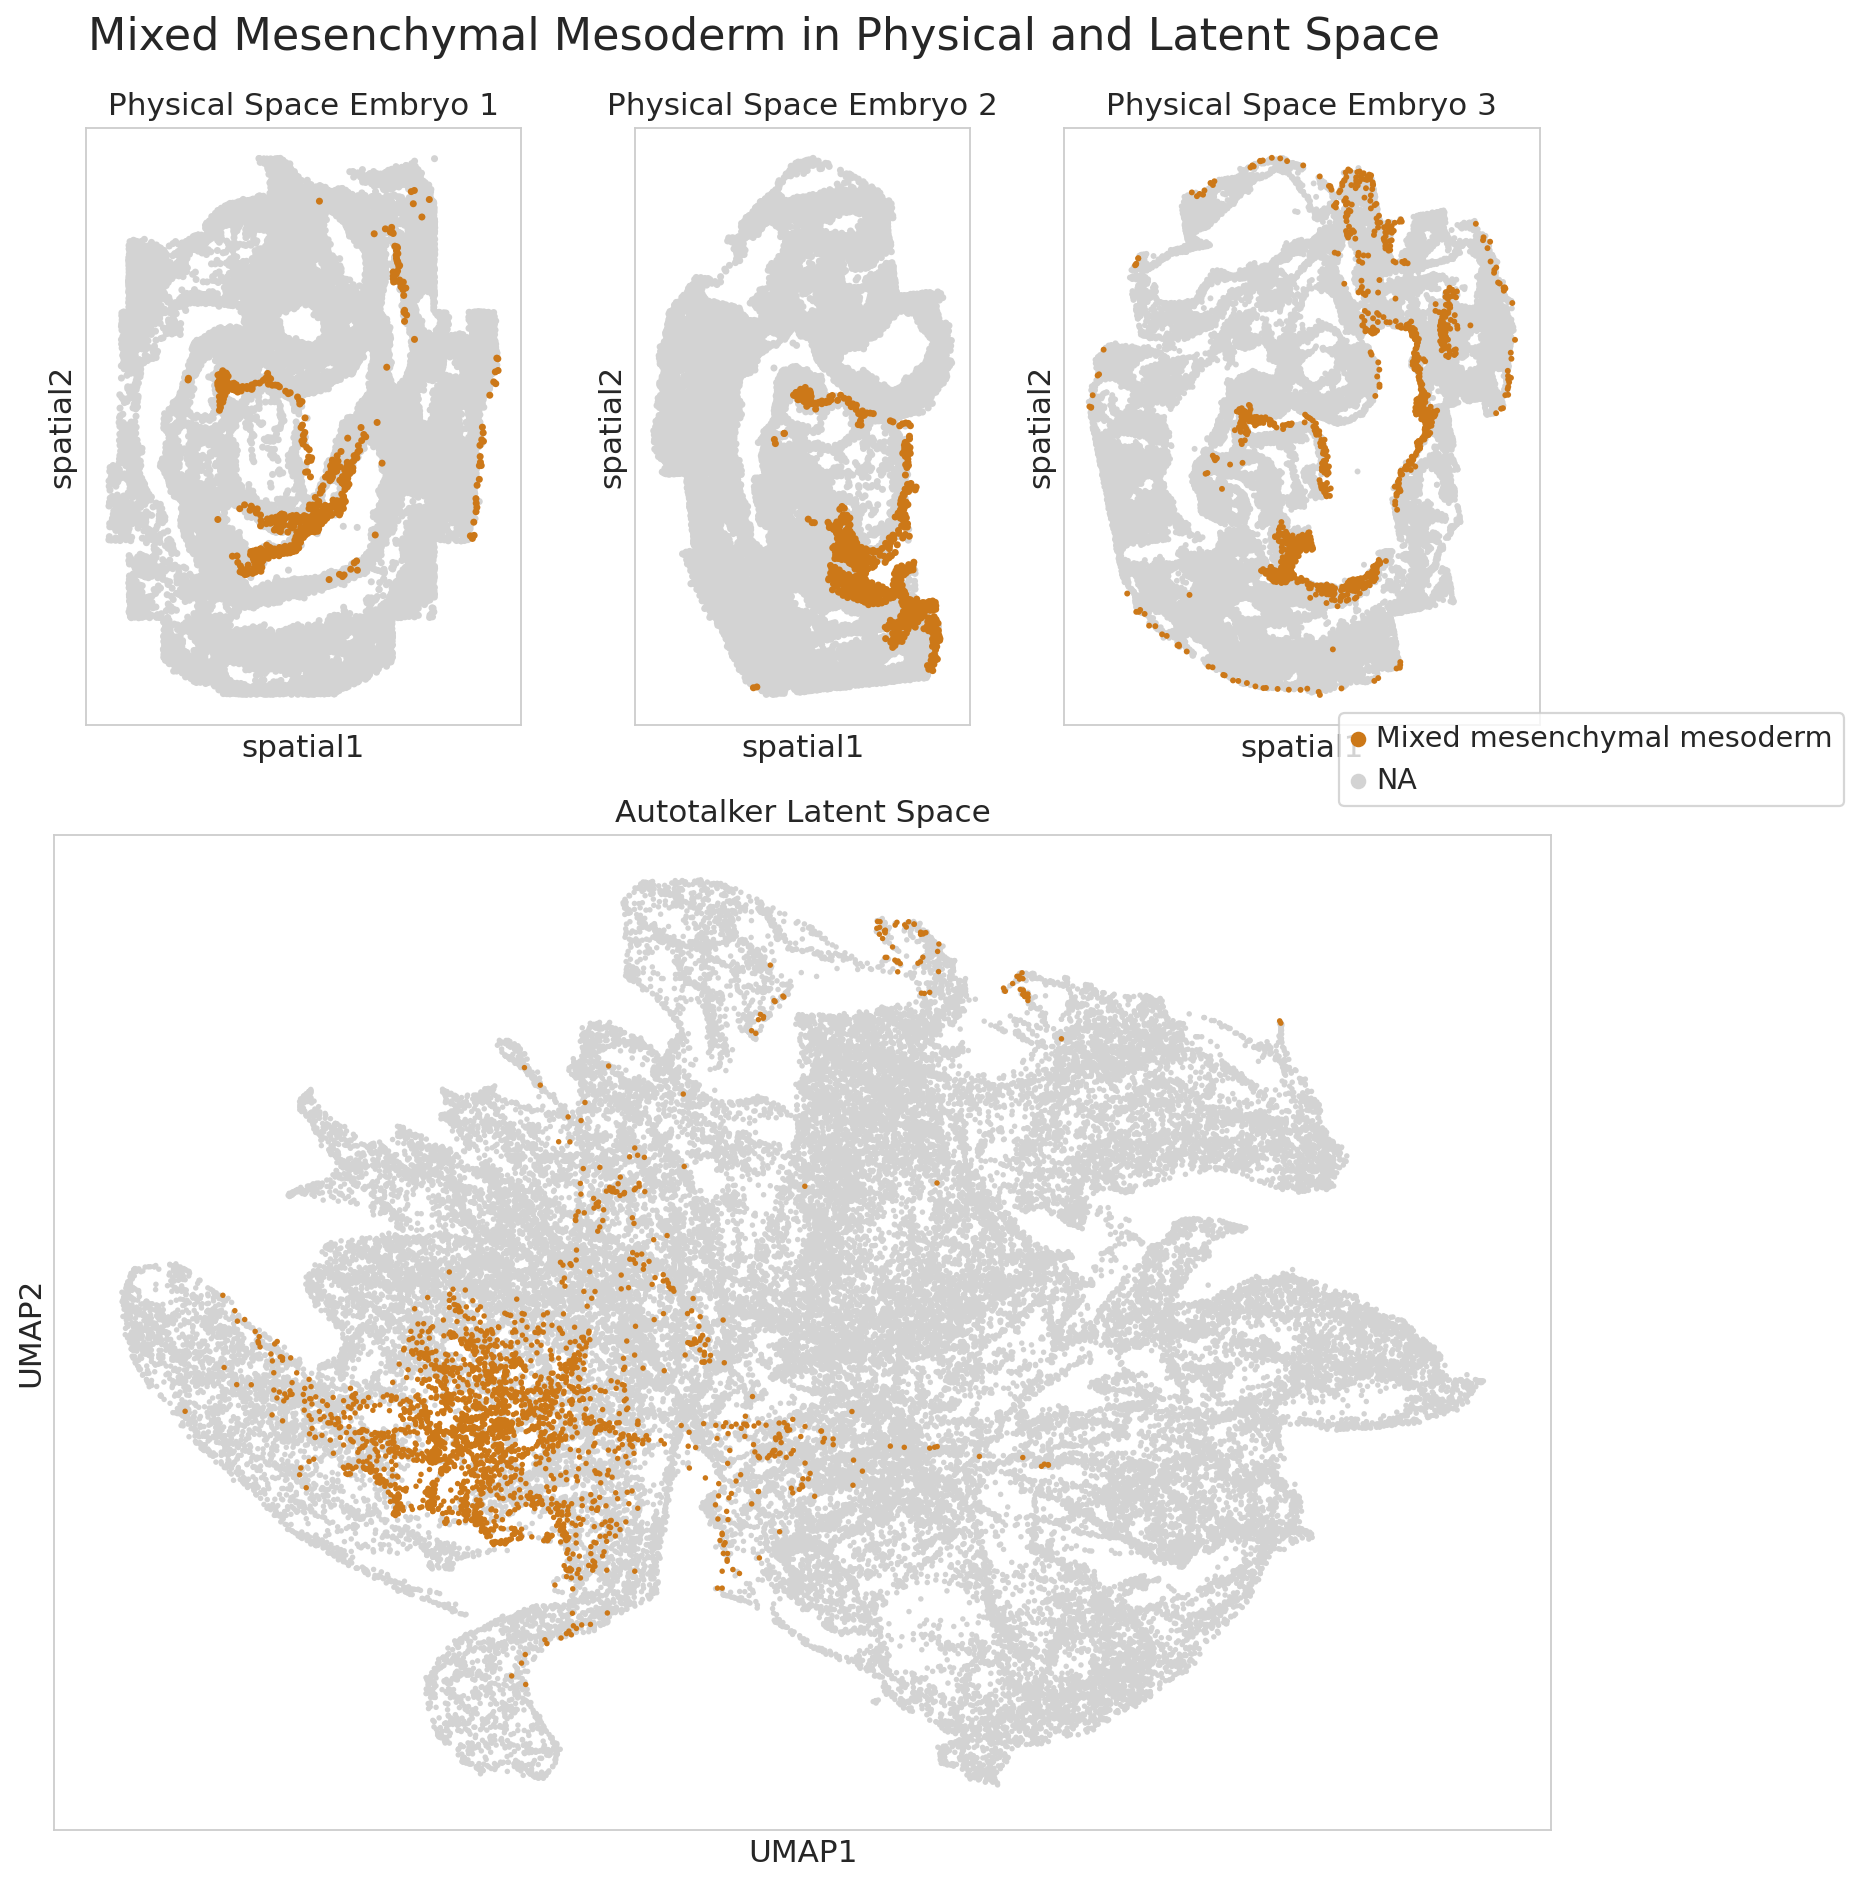

In [67]:
plot_physical_latent_for_cell_types(adata=model.adata,
                                    cell_types=["Mixed mesenchymal mesoderm"],
                                    save_fig=False)

In [73]:
cell_type_adata = model.adata[model.adata.obs[cell_type_key] == cell_type.replace("_", " ").capitalize()]

In [74]:
# Compute latent nearest neighbor graph for cell type only
sc.pp.neighbors(cell_type_adata,
                use_rep=latent_key,
                key_added=f"{cell_type}_latent_knng")

# Compute latent Leiden clustering for cell type
sc.tl.leiden(adata=cell_type_adata,
             resolution=cell_type_latent_resolution,
             random_state=random_seed,
             key_added=cell_type_latent_cluster_key,
             adjacency=cell_type_adata.obsp[f"{cell_type}_latent_knng_connectivities"])

# Use cell type latent space for UMAP generation
sc.tl.umap(cell_type_adata,
           neighbors_key=f"{cell_type}_latent_knng")

In [75]:
model.adata.obs[cell_type_latent_cluster_key] = np.nan
model.adata.obs.loc[model.adata.obs[cell_type_key] == cell_type.replace("_", " ").capitalize(),
                    cell_type_latent_cluster_key] = cell_type_adata.obs[cell_type_latent_cluster_key]

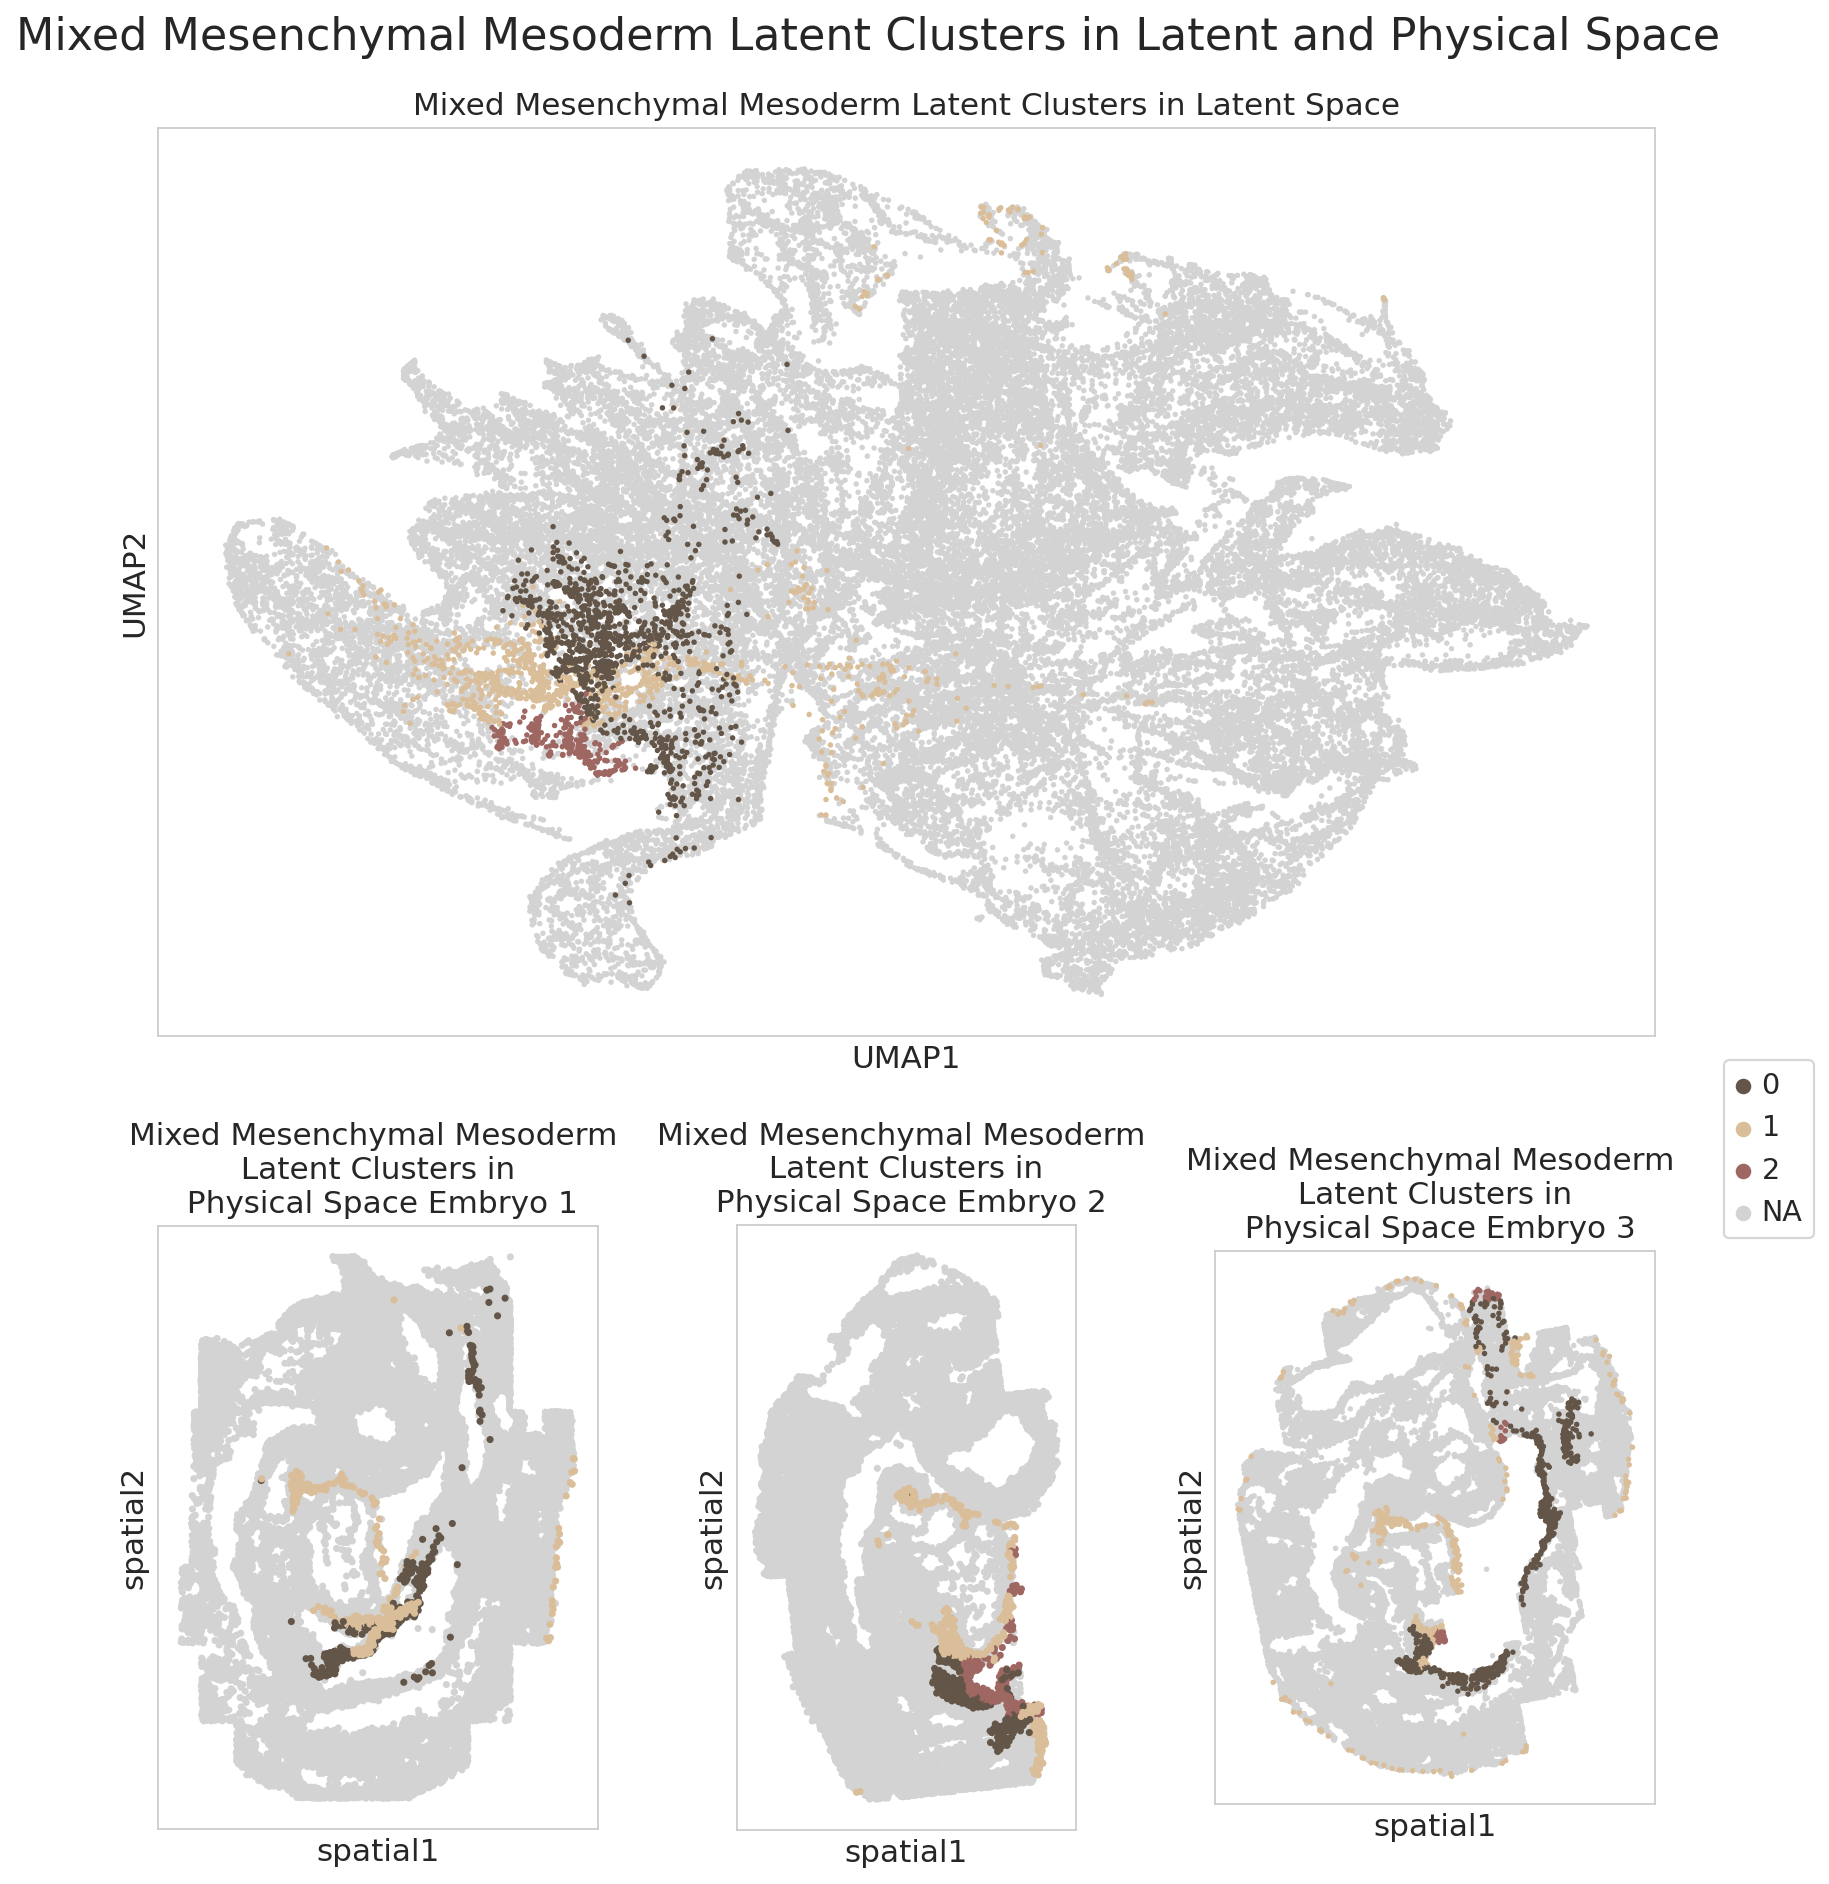

In [82]:
plot_latent_physical_for_cell_type_latent_clusters(adata=model.adata,
                                                   cell_type="mixed_mesenchymal_mesoderm",
                                                   save_fig=False)

In [ ]:
model.adata.obs[sub_cell_type_key] = model.adata.obs.apply(lambda row: add_sub_cell_type(row), axis=1)
model.adata.obs[sub_cell_type_key] = model.adata.obs[sub_cell_type_key].astype("category")

In [ ]:
sq.gr.nhood_enrichment(model.adata, cluster_key=sub_cell_type_key)

In [ ]:
cell_types = model.adata.obs[sub_cell_type_key].unique().tolist()
cell_types.sort()

#### Latent Cluster 0

- FGF Signaling

In [ ]:
def get_differential_analysis_results(analysis_label,
                                      model,
                                      adata,
                                      cat_key,
                                      selected_cats,
                                      differential_gp_scores_key,
                                      comparison_cats=None,
                                      selected_gps=None,
                                      n_top_up_gps=3,
                                      n_top_down_gps=3,
                                      feature_spaces=["latent"], # "physical_embryo1", "physical_embryo2", "physical_embryo3"
                                      save_figs=False):

In [ ]:
[[zscore, cell_type] for zscore, cell_type in sorted(
    zip(model.adata.uns[f"{sub_cell_type_key}_nhood_enrichment"]["zscore"][15], cell_types), reverse=True)][:3]

In [ ]:
analysis_label = "mixed_mesenchymal_mesoderm_latent_cluster"
selected_cats = ["0"]
comparison_cats = ["1", "2", "3", "4"]

# Compute gene program enrichments and retrieve top up- and downregulated gene programs
top_unique_gps = model.compute_differential_gp_scores(cat_key=cell_type_latent_cluster_key,
                                                      adata=model.adata,
                                                      selected_gps=None,
                                                      selected_cats=selected_cats,
                                                      gp_scores_weight_normalization=False,
                                                      comparison_cats=comparison_cats,
                                                      n_sample=10000,
                                                      key_added=cell_type_differential_gp_scores_key,
                                                      n_top_up_gps_retrieved=n_top_up_gps,
                                                      n_top_down_gps_retrieved=n_top_down_gps,
                                                      seed=random_seed)

# Display top upregulated gene programs
top_up_gp_df = model.adata.uns[cell_type_differential_gp_scores_key][:n_top_up_gps]
display(top_up_gp_df)

# Display top downregulated gene programs
top_down_gp_df = model.adata.uns[cell_type_differential_gp_scores_key][-n_top_down_gps:][::-1]
display(top_down_gp_df)

fig = sc.pl.dotplot(model.adata,
                    top_unique_gps,
                    groupby=cell_type_latent_cluster_key,
                    dendrogram=True, 
                    title=f"{analysis_label.replace('_', ' ').title()} Differential GP Scores",
                    swap_axes=True,
                    return_fig=True)
# Save and display plot
fig.savefig(f"{figure_folder_path}/{analysis_label}_differential_gp_scores.png")
plt.show()

# Inspect top up- and downregulated gene programs
display(gp_summary_df[gp_summary_df["gp_name"].isin(top_unique_gps)])

top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()

#cell_type_adata.uns[cell_type_differential_gp_scores_key] = model.adata.uns[cell_type_differential_gp_scores_key]

#for gp in top_unique_gps:
#    cell_type_adata.obs[gp] = model.adata.obs.loc[cell_type_adata.obs.index, gp]

top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()

get_cat_gp_score_gene_expr_summary(analysis_label="mixed_mesenchymal_mesoderm_latent_cluster",
                                   model=model,
                                   cats=top_cats,
                                   gps=top_gps,
                                   cat_key=cell_type_latent_cluster_key,
                                   adata=None,
                                   feature_spaces=["latent"], # "physical_embryo1", "physical_embryo2", "physical_embryo3"
                                   plot_types=["gene_categories", "individual_genes"])

#### Latent Cluster 1

BMP signaling

In [ ]:
[[zscore, cell_type] for zscore, cell_type in sorted(
    zip(model.adata.uns[f"{sub_cell_type_key}_nhood_enrichment"]["zscore"][16], cell_types), reverse=True)][:3]

In [ ]:
analysis_label = "mixed_mesenchymal_mesoderm_latent_cluster"
selected_cats = ["1"]
comparison_cats = ["0", "2", "3", "4"]

# Compute gene program enrichments and retrieve top up- and downregulated gene programs
top_unique_gps = model.compute_differential_gp_scores(cat_key=cell_type_latent_cluster_key,
                                                      adata=model.adata,
                                                      selected_gps=None,
                                                      selected_cats=selected_cats,
                                                      gp_scores_weight_normalization=False,
                                                      comparison_cats=comparison_cats,
                                                      n_sample=10000,
                                                      key_added=cell_type_differential_gp_scores_key,
                                                      n_top_up_gps_retrieved=n_top_up_gps,
                                                      n_top_down_gps_retrieved=n_top_down_gps,
                                                      seed=random_seed)

# Display top upregulated gene programs
top_up_gp_df = model.adata.uns[cell_type_differential_gp_scores_key][:n_top_up_gps]
display(top_up_gp_df)

# Display top downregulated gene programs
top_down_gp_df = model.adata.uns[cell_type_differential_gp_scores_key][-n_top_down_gps:][::-1]
display(top_down_gp_df)

fig = sc.pl.dotplot(model.adata,
                    top_unique_gps,
                    groupby=cell_type_latent_cluster_key,
                    dendrogram=True, 
                    title=f"{analysis_label.replace('_', ' ').title()} Differential GP Scores",
                    swap_axes=True,
                    return_fig=True)
# Save and display plot
fig.savefig(f"{figure_folder_path}/{analysis_label}_differential_gp_scores.png")
plt.show()

# Inspect top up- and downregulated gene programs
display(gp_summary_df[gp_summary_df["gp_name"].isin(top_unique_gps)])

top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()

cell_type_adata.uns[cell_type_differential_gp_scores_key] = model.adata.uns[cell_type_differential_gp_scores_key]

for gp in top_unique_gps:
    cell_type_adata.obs[gp] = model.adata.obs.loc[cell_type_adata.obs.index, gp]

top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()

get_cat_gp_score_gene_expr_summary(analysis_label="mixed_mesenchymal_mesoderm_latent_cluster",
                                   model=model,
                                   cats=top_cats,
                                   gps=top_gps,
                                   cat_key=cell_type_latent_cluster_key,
                                   adata=cell_type_adata,
                                   feature_spaces=["latent"], # "physical_embryo1", "physical_embryo2", "physical_embryo3"
                                   plot_types=["gene_categories", "individual_genes"])

#### Latent Cluster 2

In [ ]:
[[zscore, cell_type] for zscore, cell_type in sorted(
    zip(model.adata.uns[f"{sub_cell_type_key}_nhood_enrichment"]["zscore"][17], cell_types), reverse=True)][:3]

In [ ]:
analysis_label = "mixed_mesenchymal_mesoderm_latent_cluster"
selected_cats = ["2"]
comparison_cats = ["0", "1", "3", "4"]

# Compute gene program enrichments and retrieve top up- and downregulated gene programs
top_unique_gps = model.compute_differential_gp_scores(cat_key=cell_type_latent_cluster_key,
                                                      adata=model.adata,
                                                      selected_gps=None,
                                                      selected_cats=selected_cats,
                                                      gp_scores_weight_normalization=False,
                                                      comparison_cats=comparison_cats,
                                                      n_sample=10000,
                                                      key_added=cell_type_differential_gp_scores_key,
                                                      n_top_up_gps_retrieved=n_top_up_gps,
                                                      n_top_down_gps_retrieved=n_top_down_gps,
                                                      seed=random_seed)

# Display top upregulated gene programs
top_up_gp_df = model.adata.uns[cell_type_differential_gp_scores_key][:n_top_up_gps]
display(top_up_gp_df)

# Display top downregulated gene programs
top_down_gp_df = model.adata.uns[cell_type_differential_gp_scores_key][-n_top_down_gps:][::-1]
display(top_down_gp_df)

fig = sc.pl.dotplot(model.adata,
                    top_unique_gps,
                    groupby=cell_type_latent_cluster_key,
                    dendrogram=True, 
                    title=f"{analysis_label.replace('_', ' ').title()} Differential GP Scores",
                    swap_axes=True,
                    return_fig=True)
# Save and display plot
fig.savefig(f"{figure_folder_path}/{analysis_label}_differential_gp_scores.png")
plt.show()

# Inspect top up- and downregulated gene programs
display(gp_summary_df[gp_summary_df["gp_name"].isin(top_unique_gps)])

top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()

cell_type_adata.uns[cell_type_differential_gp_scores_key] = model.adata.uns[cell_type_differential_gp_scores_key]

for gp in top_unique_gps:
    cell_type_adata.obs[gp] = model.adata.obs.loc[cell_type_adata.obs.index, gp]

top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()

get_cat_gp_score_gene_expr_summary(analysis_label="mixed_mesenchymal_mesoderm_latent_cluster",
                                   model=model,
                                   cats=top_cats,
                                   gps=top_gps,
                                   cat_key=cell_type_latent_cluster_key,
                                   adata=cell_type_adata,
                                   feature_spaces=["latent"], # "physical_embryo1", "physical_embryo2", "physical_embryo3"
                                   plot_types=["gene_categories", "individual_genes"])

#### Latent Cluster 3

In [ ]:
[[zscore, cell_type] for zscore, cell_type in sorted(
    zip(model.adata.uns[f"{sub_cell_type_key}_nhood_enrichment"]["zscore"][18], cell_types), reverse=True)][:3]

In [ ]:
analysis_label = "mixed_mesenchymal_mesoderm_latent_cluster"
selected_cats = ["3"]
comparison_cats = ["0", "1", "2", "4"]

# Compute gene program enrichments and retrieve top up- and downregulated gene programs
top_unique_gps = model.compute_differential_gp_scores(cat_key=cell_type_latent_cluster_key,
                                                      adata=model.adata,
                                                      selected_gps=None,
                                                      selected_cats=selected_cats,
                                                      gp_scores_weight_normalization=False,
                                                      comparison_cats=comparison_cats,
                                                      n_sample=10000,
                                                      key_added=cell_type_differential_gp_scores_key,
                                                      n_top_up_gps_retrieved=n_top_up_gps,
                                                      n_top_down_gps_retrieved=n_top_down_gps,
                                                      seed=random_seed)

# Display top upregulated gene programs
top_up_gp_df = model.adata.uns[cell_type_differential_gp_scores_key][:n_top_up_gps]
display(top_up_gp_df)

# Display top downregulated gene programs
top_down_gp_df = model.adata.uns[cell_type_differential_gp_scores_key][-n_top_down_gps:][::-1]
display(top_down_gp_df)

fig = sc.pl.dotplot(model.adata,
                    top_unique_gps,
                    groupby=cell_type_latent_cluster_key,
                    dendrogram=True, 
                    title=f"{analysis_label.replace('_', ' ').title()} Differential GP Scores",
                    swap_axes=True,
                    return_fig=True)
# Save and display plot
fig.savefig(f"{figure_folder_path}/{analysis_label}_differential_gp_scores.png")
plt.show()

# Inspect top up- and downregulated gene programs
display(gp_summary_df[gp_summary_df["gp_name"].isin(top_unique_gps)])

top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()

cell_type_adata.uns[cell_type_differential_gp_scores_key] = model.adata.uns[cell_type_differential_gp_scores_key]

for gp in top_unique_gps:
    cell_type_adata.obs[gp] = model.adata.obs.loc[cell_type_adata.obs.index, gp]

top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()

get_cat_gp_score_gene_expr_summary(analysis_label="mixed_mesenchymal_mesoderm_latent_cluster",
                                   model=model,
                                   cats=top_cats,
                                   gps=top_gps,
                                   cat_key=cell_type_latent_cluster_key,
                                   adata=cell_type_adata,
                                   feature_spaces=["latent"], # "physical_embryo1", "physical_embryo2", "physical_embryo3"
                                   plot_types=["gene_categories", "individual_genes"])

#### Latent Cluster 4

In [ ]:
[[zscore, cell_type] for zscore, cell_type in sorted(
    zip(model.adata.uns[f"{sub_cell_type_key}_nhood_enrichment"]["zscore"][19], cell_types), reverse=True)][:3]

In [ ]:
analysis_label = "mixed_mesenchymal_mesoderm_latent_cluster"
selected_cats = ["4"]
comparison_cats = ["0", "1", "2", "3"]

# Compute gene program enrichments and retrieve top up- and downregulated gene programs
top_unique_gps = model.compute_differential_gp_scores(cat_key=cell_type_latent_cluster_key,
                                                      adata=model.adata,
                                                      selected_gps=None,
                                                      selected_cats=selected_cats,
                                                      gp_scores_weight_normalization=False,
                                                      comparison_cats=comparison_cats,
                                                      n_sample=10000,
                                                      key_added=cell_type_differential_gp_scores_key,
                                                      n_top_up_gps_retrieved=n_top_up_gps,
                                                      n_top_down_gps_retrieved=n_top_down_gps,
                                                      seed=random_seed)

# Display top upregulated gene programs
top_up_gp_df = model.adata.uns[cell_type_differential_gp_scores_key][:n_top_up_gps]
display(top_up_gp_df)

# Display top downregulated gene programs
top_down_gp_df = model.adata.uns[cell_type_differential_gp_scores_key][-n_top_down_gps:][::-1]
display(top_down_gp_df)

fig = sc.pl.dotplot(model.adata,
                    top_unique_gps,
                    groupby=cell_type_latent_cluster_key,
                    dendrogram=True, 
                    title=f"{analysis_label.replace('_', ' ').title()} Differential GP Scores",
                    swap_axes=True,
                    return_fig=True)
# Save and display plot
fig.savefig(f"{figure_folder_path}/{analysis_label}_differential_gp_scores.png")
plt.show()

# Inspect top up- and downregulated gene programs
display(gp_summary_df[gp_summary_df["gp_name"].isin(top_unique_gps)])

top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()

cell_type_adata.uns[cell_type_differential_gp_scores_key] = model.adata.uns[cell_type_differential_gp_scores_key]

for gp in top_unique_gps:
    cell_type_adata.obs[gp] = model.adata.obs.loc[cell_type_adata.obs.index, gp]

top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()

get_cat_gp_score_gene_expr_summary(analysis_label="mixed_mesenchymal_mesoderm_latent_cluster",
                                   model=model,
                                   cats=top_cats,
                                   gps=top_gps,
                                   cat_key=cell_type_latent_cluster_key,
                                   adata=cell_type_adata,
                                   feature_spaces=["latent"], # "physical_embryo1", "physical_embryo2", "physical_embryo3"
                                   plot_types=["gene_categories", "individual_genes"])

### 3.3 Forebrain/Midbrain/Hindbrain

- Regionally specific developing brain subtypes: separation into Rhombencephalon, Tegmentum, Mesencephalon, Prosencephalon

In [84]:
cell_type = "Forebrain/Midbrain/Hindbrain"
cell_type_latent_resolution = 0.07
cell_type_latent_cluster_key = f"{cell_type}_latent_leiden_{cell_type_latent_resolution}"
cell_type_latent_cluster_emphasis_key = f"{cell_type_latent_cluster_key}_emphasis"
cell_type_differential_gp_scores_key = f"{cell_type}_differential_gp_scores"

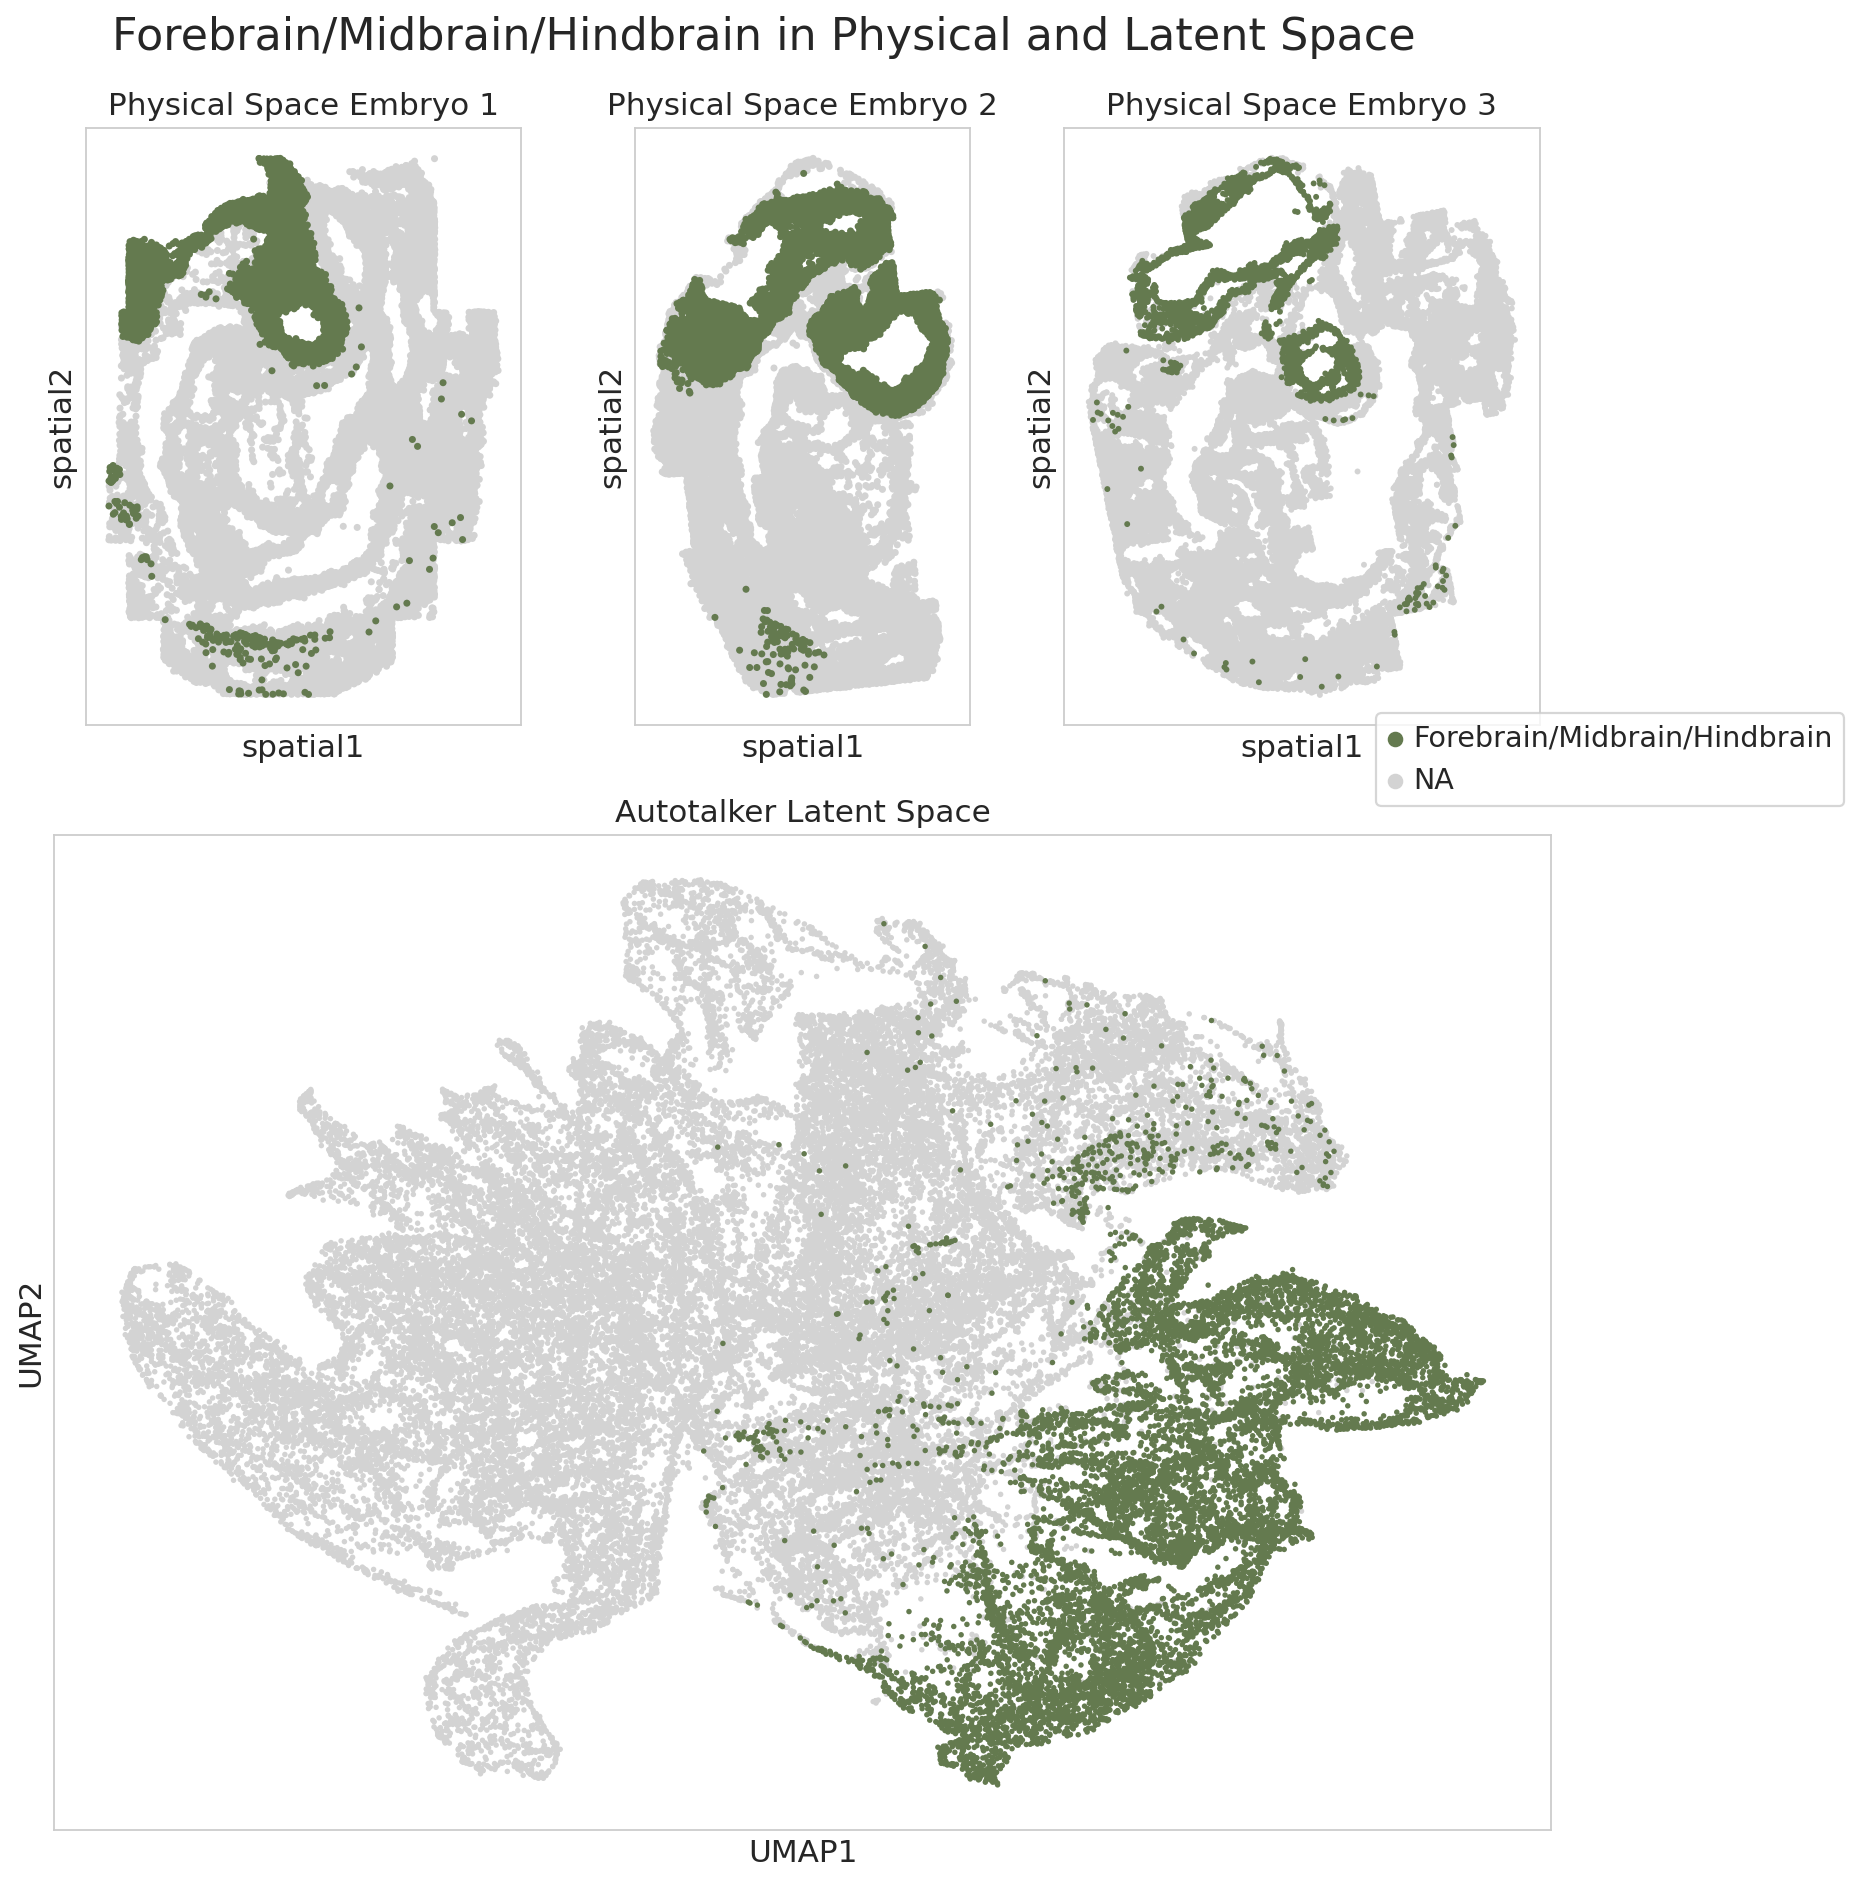

In [85]:
plot_physical_latent_for_cell_types(adata=model.adata,
                                    cell_types=["Forebrain/Midbrain/Hindbrain"],
                                    save_fig=False)

In [86]:
cell_type_adata = model.adata[model.adata.obs[cell_type_key] == cell_type]

In [87]:
# Compute latent nearest neighbor graph for cell type only
sc.pp.neighbors(cell_type_adata,
                use_rep=latent_key,
                key_added=f"{cell_type.replace('/', '_').lower()}_latent_knng")

# Compute latent Leiden clustering for cell type
sc.tl.leiden(adata=cell_type_adata,
             resolution=cell_type_latent_resolution,
             random_state=random_seed,
             key_added=cell_type_latent_cluster_key,
             adjacency=cell_type_adata.obsp[f"{cell_type.replace('/', '_').lower()}_latent_knng_connectivities"])

# Use cell type latent space for UMAP generation
sc.tl.umap(cell_type_adata,
           neighbors_key=f"{cell_type.replace('/', '_').lower()}_latent_knng")

In [88]:
model.adata.obs[cell_type_latent_cluster_key] = np.nan
model.adata.obs.loc[model.adata.obs[cell_type_key] == cell_type,
                    cell_type_latent_cluster_key] = cell_type_adata.obs[cell_type_latent_cluster_key]

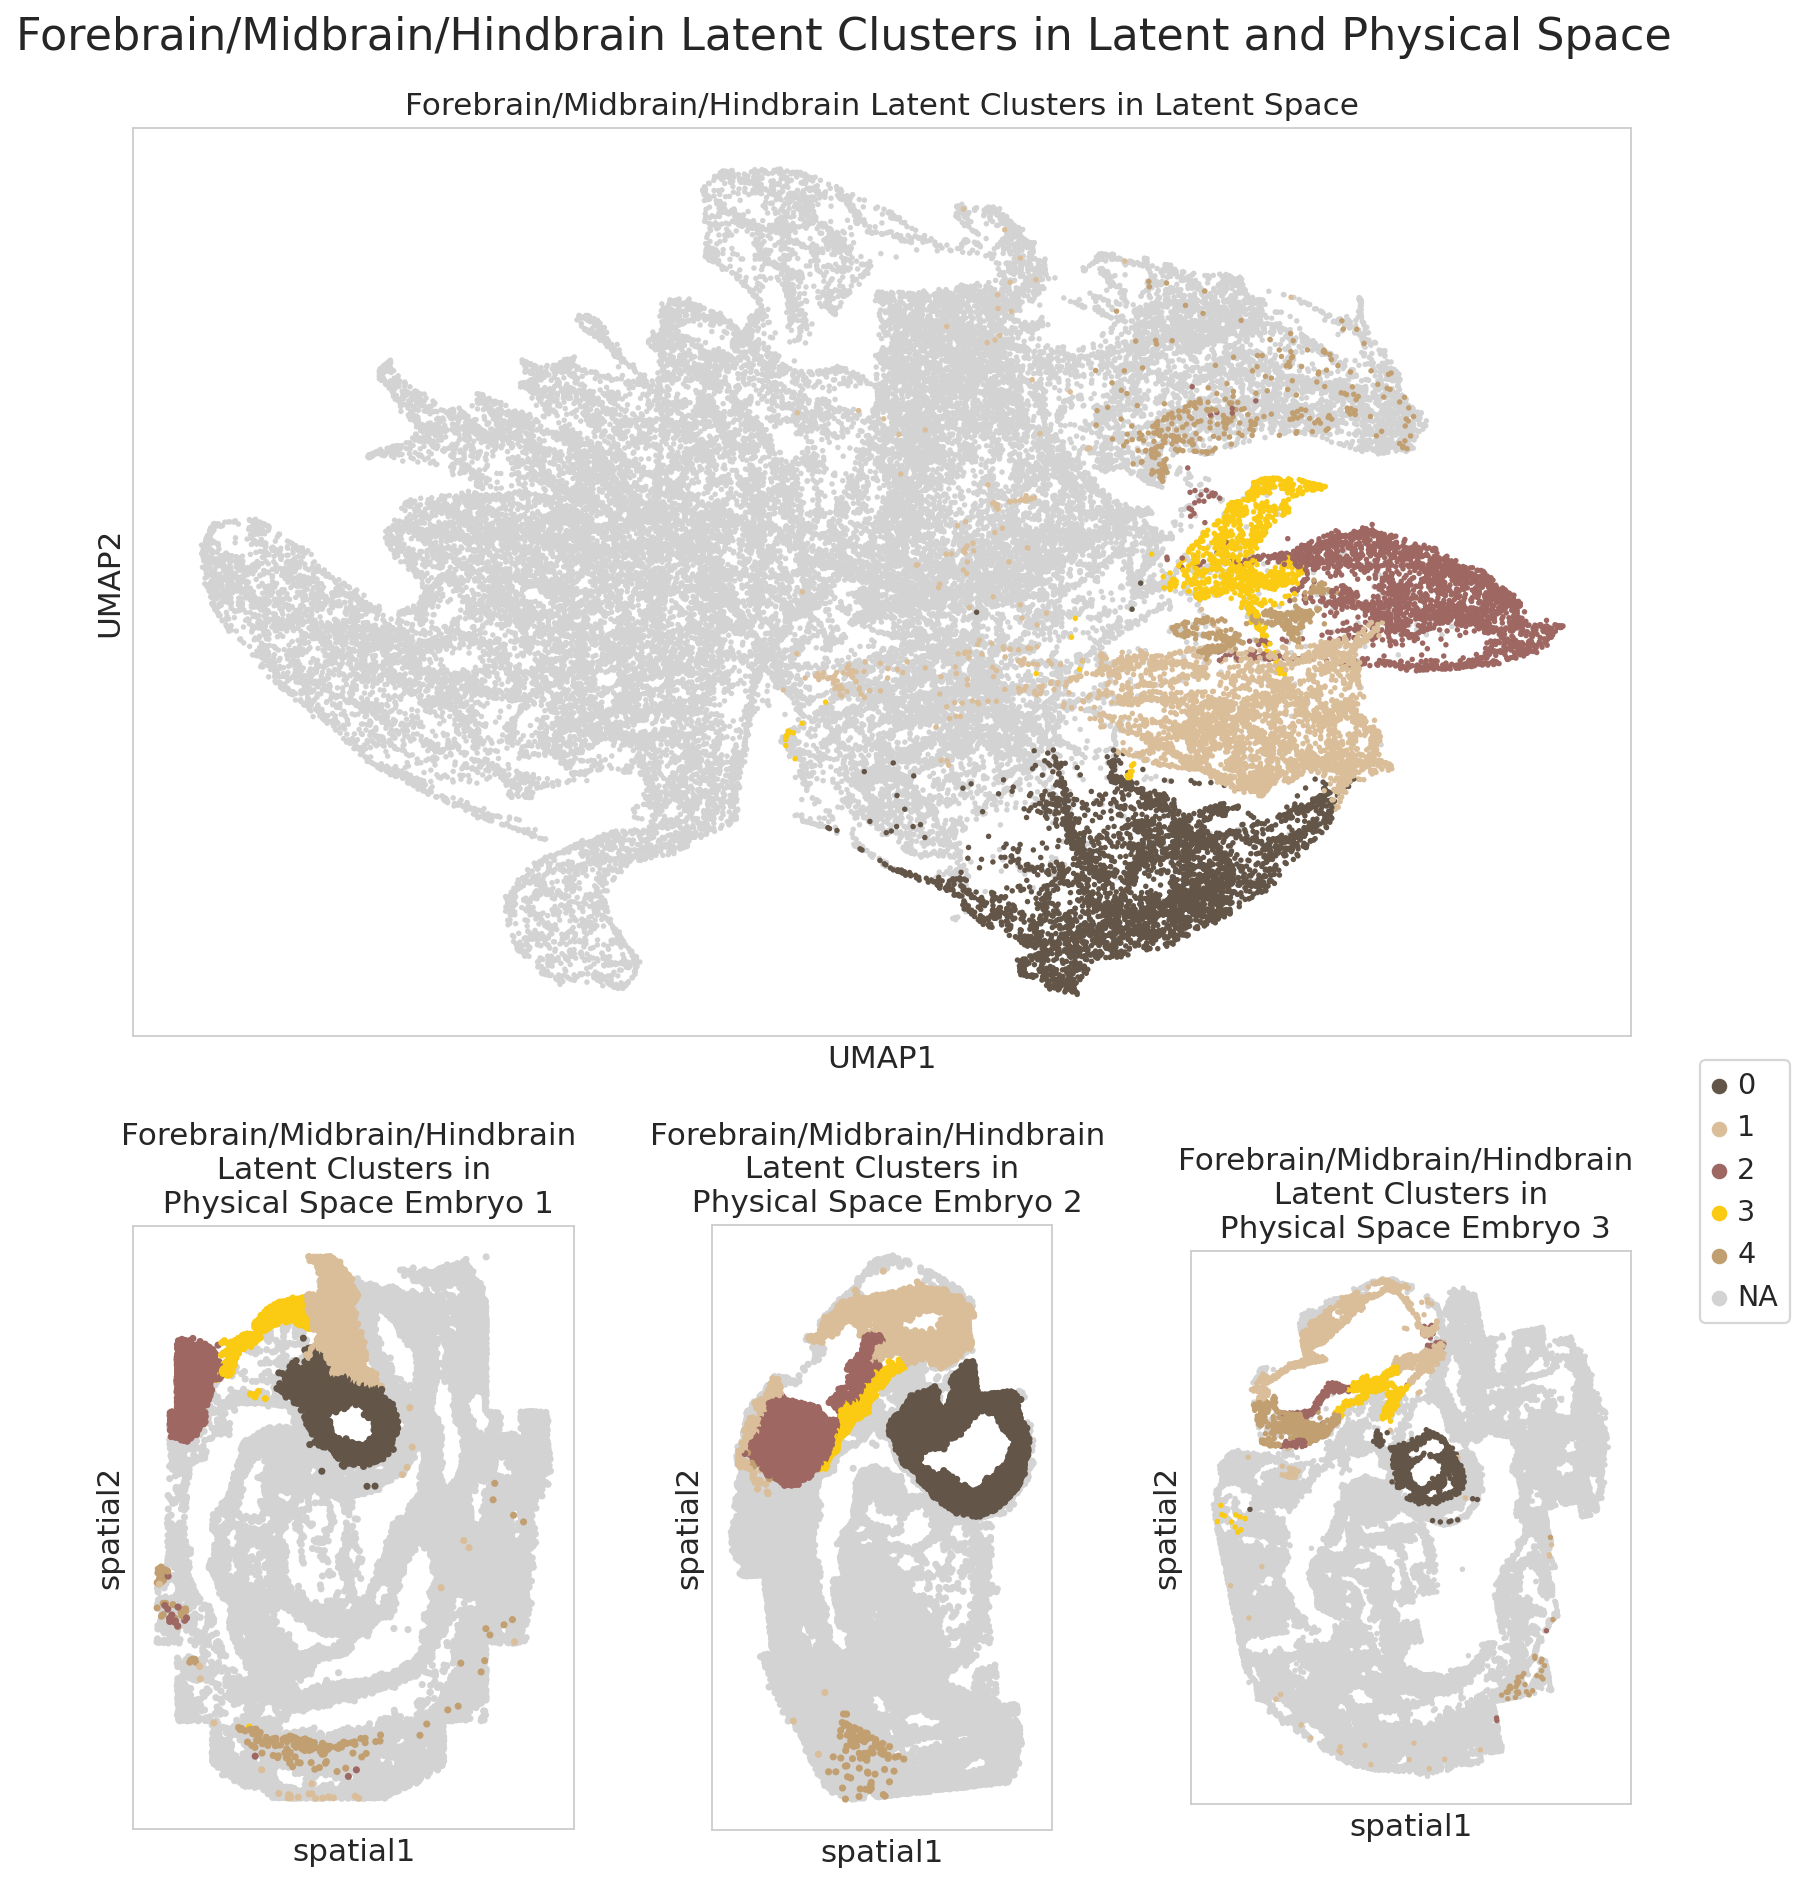

In [89]:
plot_latent_physical_for_cell_type_latent_clusters(adata=model.adata,
                                                   cell_type="Forebrain/Midbrain/Hindbrain",
                                                   save_fig=True)

In [ ]:
# Create plot of cell type annotations in physical and latent space
fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"{cell_type} Latent Clusters in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=3,
                          nrows=2,
                          width_ratios=[1, 1, 1],
                          height_ratios=[3, 2])
ax1 = fig.add_subplot(spec1[0])
ax2 = fig.add_subplot(spec2[3])
ax3 = fig.add_subplot(spec2[4])
ax4 = fig.add_subplot(spec2[5])
sc.pl.umap(adata=model.adata,
           color=[cell_type_latent_cluster_key],
           palette=latent_cluster_colors,
           size=1280000/len(model.adata),
           title=f"{cell_type} Latent Clusters in Latent Space",
           ax=ax1,
           show=False)
sc.pl.spatial(adata=model.adata[model.adata.obs["sample"] == "embryo1"],
              color=[cell_type_latent_cluster_key],
              palette=latent_cluster_colors,
              size=160000/len(model.adata),
              spot_size=0.03,
              title=f"{cell_type} \n Latent Clusters in \n Physical Space Embryo 1",
              legend_loc=None,
              ax=ax2,
              show=False)
sc.pl.spatial(adata=model.adata[model.adata.obs["sample"] == "embryo2"],
              color=[cell_type_latent_cluster_key],
              palette=latent_cluster_colors,
              size=160000/len(model.adata),
              spot_size=0.03,
              title=f"{cell_type} \n Latent Clusters in \n Physical Space Embryo 2",
              legend_loc=None,
              ax=ax3,
              show=False)
sc.pl.spatial(adata=model.adata[model.adata.obs["sample"] == "embryo3"],
              color=[cell_type_latent_cluster_key],
              palette=latent_cluster_colors,
              size=160000/len(model.adata),
              spot_size=0.03,
              title=f"{cell_type} \n Latent Clusters in \n Physical Space Embryo 3",
              legend_loc=None,
              ax=ax4,
              show=False)

# Create and position shared legend
handles, labels = ax1.get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=(1.05, 0.5))
ax1.get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
#fig.savefig(f"{figure_folder_path}/{cell_type}_latent_clusters_physical_latent_space.png",
#            bbox_extra_artists=(lgd, title),
#            bbox_inches="tight")
plt.show()

#### Latent Cluster 0

In [ ]:
analysis_label = "forebrain_midbrain_hindbrain_latent_cluster"
selected_cats = ["0"]
comparison_cats = ["1", "2", "3", "4"]

model.adata.obs[cell_type_latent_cluster_emphasis_key] = model.adata.obs.apply(
    lambda row: add_cell_type_latent_cluster_emphasis(row, comparison_cats), axis=1)
model.adata.obs[cell_type_latent_cluster_emphasis_key] = model.adata.obs[cell_type_latent_cluster_emphasis_key].astype("category")

# Compute gene program enrichments and retrieve top up- and downregulated gene programs
top_unique_gps = model.compute_differential_gp_scores(cat_key=cell_type_latent_cluster_key,
                                                      adata=model.adata,
                                                      selected_gps=None,
                                                      selected_cats=selected_cats,
                                                      gp_scores_weight_normalization=False,
                                                      comparison_cats=comparison_cats,
                                                      n_sample=10000,
                                                      key_added=cell_type_differential_gp_scores_key,
                                                      n_top_up_gps_retrieved=n_top_up_gps,
                                                      n_top_down_gps_retrieved=n_top_down_gps,
                                                      seed=random_seed)

# Display top upregulated gene programs
top_up_gp_df = model.adata.uns[cell_type_differential_gp_scores_key][:n_top_up_gps]
display(top_up_gp_df)

# Display top downregulated gene programs
top_down_gp_df = model.adata.uns[cell_type_differential_gp_scores_key][-n_top_down_gps:][::-1]
display(top_down_gp_df)

fig = sc.pl.dotplot(model.adata,
                    top_unique_gps,
                    groupby=cell_type_latent_cluster_key,
                    dendrogram=True, 
                    title=f"{analysis_label.replace('_', ' ').title()} Differential GP Scores",
                    swap_axes=True,
                    return_fig=True)
# Save and display plot
fig.savefig(f"{figure_folder_path}/{analysis_label}_differential_gp_scores.png")
plt.show()

# Inspect top up- and downregulated gene programs
display(gp_summary_df[gp_summary_df["gp_name"].isin(top_unique_gps)])

top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()

#cell_type_adata.uns[cell_type_differential_gp_scores_key] = model.adata.uns[cell_type_differential_gp_scores_key]

#for gp in top_unique_gps:
#    cell_type_adata.obs[gp] = model.adata.obs.loc[cell_type_adata.obs.index, gp]

top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()

get_cat_gp_score_gene_expr_summary(analysis_label="mixed_mesenchymal_mesoderm_latent_cluster",
                                   model=model,
                                   cats=top_cats,
                                   gps=top_gps,
                                   cat_key=cell_type_latent_cluster_emphasis_key,
                                   adata=None,
                                   feature_spaces=["latent"], # "physical_embryo1", "physical_embryo2", "physical_embryo3"
                                   plot_types=["gene_categories", "individual_genes"])

#### Latent Cluster 1

In [ ]:
analysis_label = "forebrain_midbrain_hindbrain_latent_cluster"
selected_cats = ["1"]
comparison_cats = ["0", "2", "3", "4"]

# Compute gene program enrichments and retrieve top up- and downregulated gene programs
top_unique_gps = model.compute_differential_gp_scores(cat_key=cell_type_latent_cluster_key,
                                                      adata=model.adata,
                                                      selected_gps=None,
                                                      selected_cats=selected_cats,
                                                      gp_scores_weight_normalization=False,
                                                      comparison_cats=comparison_cats,
                                                      n_sample=10000,
                                                      key_added=cell_type_differential_gp_scores_key,
                                                      n_top_up_gps_retrieved=n_top_up_gps,
                                                      n_top_down_gps_retrieved=n_top_down_gps,
                                                      seed=random_seed)

# Display top upregulated gene programs
top_up_gp_df = model.adata.uns[cell_type_differential_gp_scores_key][:n_top_up_gps]
display(top_up_gp_df)

# Display top downregulated gene programs
top_down_gp_df = model.adata.uns[cell_type_differential_gp_scores_key][-n_top_down_gps:][::-1]
display(top_down_gp_df)

fig = sc.pl.dotplot(model.adata,
                    top_unique_gps,
                    groupby=cell_type_latent_cluster_key,
                    dendrogram=True, 
                    title=f"{analysis_label.replace('_', ' ').title()} Differential GP Scores",
                    swap_axes=True,
                    return_fig=True)
# Save and display plot
fig.savefig(f"{figure_folder_path}/{analysis_label}_differential_gp_scores.png")
plt.show()

# Inspect top up- and downregulated gene programs
display(gp_summary_df[gp_summary_df["gp_name"].isin(top_unique_gps)])

top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()

cell_type_adata.uns[cell_type_differential_gp_scores_key] = model.adata.uns[cell_type_differential_gp_scores_key]

for gp in top_unique_gps:
    cell_type_adata.obs[gp] = model.adata.obs.loc[cell_type_adata.obs.index, gp]

top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()

get_cat_gp_score_gene_expr_summary(analysis_label="mixed_mesenchymal_mesoderm_latent_cluster",
                                   model=model,
                                   cats=top_cats,
                                   gps=top_gps,
                                   cat_key=cell_type_latent_cluster_key,
                                   adata=cell_type_adata,
                                   feature_spaces=["latent"], # "physical_embryo1", "physical_embryo2", "physical_embryo3"
                                   plot_types=["gene_categories", "individual_genes"])

#### Latent Cluster 2

In [ ]:
analysis_label = "forebrain_midbrain_hindbrain_latent_cluster"
selected_cats = ["2"]
comparison_cats = ["0", "1", "3", "4"]

# Compute gene program enrichments and retrieve top up- and downregulated gene programs
top_unique_gps = model.compute_differential_gp_scores(cat_key=cell_type_latent_cluster_key,
                                                      adata=model.adata,
                                                      selected_gps=None,
                                                      selected_cats=selected_cats,
                                                      gp_scores_weight_normalization=False,
                                                      comparison_cats=comparison_cats,
                                                      n_sample=10000,
                                                      key_added=cell_type_differential_gp_scores_key,
                                                      n_top_up_gps_retrieved=n_top_up_gps,
                                                      n_top_down_gps_retrieved=n_top_down_gps,
                                                      seed=random_seed)

# Display top upregulated gene programs
top_up_gp_df = model.adata.uns[cell_type_differential_gp_scores_key][:n_top_up_gps]
display(top_up_gp_df)

# Display top downregulated gene programs
top_down_gp_df = model.adata.uns[cell_type_differential_gp_scores_key][-n_top_down_gps:][::-1]
display(top_down_gp_df)

fig = sc.pl.dotplot(model.adata,
                    top_unique_gps,
                    groupby=cell_type_latent_cluster_key,
                    dendrogram=True, 
                    title=f"{analysis_label.replace('_', ' ').title()} Differential GP Scores",
                    swap_axes=True,
                    return_fig=True)
# Save and display plot
fig.savefig(f"{figure_folder_path}/{analysis_label}_differential_gp_scores.png")
plt.show()

# Inspect top up- and downregulated gene programs
display(gp_summary_df[gp_summary_df["gp_name"].isin(top_unique_gps)])

top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()

cell_type_adata.uns[cell_type_differential_gp_scores_key] = model.adata.uns[cell_type_differential_gp_scores_key]

for gp in top_unique_gps:
    cell_type_adata.obs[gp] = model.adata.obs.loc[cell_type_adata.obs.index, gp]

top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()

get_cat_gp_score_gene_expr_summary(analysis_label="mixed_mesenchymal_mesoderm_latent_cluster",
                                   model=model,
                                   cats=top_cats,
                                   gps=top_gps,
                                   cat_key=cell_type_latent_cluster_key,
                                   adata=cell_type_adata,
                                   feature_spaces=["physical_embryo2"], # "latent", "physical_embryo1", "physical_embryo3"
                                   plot_types=["gene_categories", "individual_genes"])

#### Latent Cluster 3

In [ ]:
analysis_label = "forebrain_midbrain_hindbrain_latent_cluster"
selected_cats = ["3"]
comparison_cats = ["0", "1", "2", "4"]

# Compute gene program enrichments and retrieve top up- and downregulated gene programs
top_unique_gps = model.compute_differential_gp_scores(cat_key=cell_type_latent_cluster_key,
                                                      adata=model.adata,
                                                      selected_gps=None,
                                                      selected_cats=selected_cats,
                                                      gp_scores_weight_normalization=False,
                                                      comparison_cats=comparison_cats,
                                                      n_sample=10000,
                                                      key_added=cell_type_differential_gp_scores_key,
                                                      n_top_up_gps_retrieved=n_top_up_gps,
                                                      n_top_down_gps_retrieved=n_top_down_gps,
                                                      seed=random_seed)

# Display top upregulated gene programs
top_up_gp_df = model.adata.uns[cell_type_differential_gp_scores_key][:n_top_up_gps]
display(top_up_gp_df)

# Display top downregulated gene programs
top_down_gp_df = model.adata.uns[cell_type_differential_gp_scores_key][-n_top_down_gps:][::-1]
display(top_down_gp_df)

fig = sc.pl.dotplot(model.adata,
                    top_unique_gps,
                    groupby=cell_type_latent_cluster_key,
                    dendrogram=True, 
                    title=f"{analysis_label.replace('_', ' ').title()} Differential GP Scores",
                    swap_axes=True,
                    return_fig=True)
# Save and display plot
fig.savefig(f"{figure_folder_path}/{analysis_label}_differential_gp_scores.png")
plt.show()

# Inspect top up- and downregulated gene programs
display(gp_summary_df[gp_summary_df["gp_name"].isin(top_unique_gps)])

top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()

cell_type_adata.uns[cell_type_differential_gp_scores_key] = model.adata.uns[cell_type_differential_gp_scores_key]

for gp in top_unique_gps:
    cell_type_adata.obs[gp] = model.adata.obs.loc[cell_type_adata.obs.index, gp]

top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()

get_cat_gp_score_gene_expr_summary(analysis_label="mixed_mesenchymal_mesoderm_latent_cluster",
                                   model=model,
                                   cats=top_cats,
                                   gps=top_gps,
                                   cat_key=cell_type_latent_cluster_key,
                                   adata=cell_type_adata,
                                   feature_spaces=["latent"], # "physical_embryo1", "physical_embryo2", "physical_embryo3"
                                   plot_types=["gene_categories", "individual_genes"])

In [ ]:
model.get_gp_summary()[model.get_gp_summary()["gp_name"] == "BMP2_ligand_targetgenes_GP"]

In [ ]:
model.adata.obsm["autotalker_latent"][:, 22]

In [ ]:
cell_type_adata.obsm["autotalker_latent"][:, 22]

In [ ]:
cell_type_adata.obs.loc[cell_type_adata.obs[cell_type_latent_cluster_key] == "1", "BMP2_ligand_targetgenes_GP"].mean()

In [ ]:
cell_type_adata.obs.loc[cell_type_adata.obs[cell_type_latent_cluster_key].isin(["0", "2"]), "BMP2_ligand_targetgenes_GP"].mean()

In [ ]:
cell_type_adata.X[cell_type_adata.obs[cell_type_latent_cluster_key] == "1", cell_type_adata.var_names == "Myl9"].mean()

In [ ]:
cell_type_adata.X[cell_type_adata.obs[cell_type_latent_cluster_key].isin(["0", "2"]), cell_type_adata.var_names == "Myl9"].mean()

In [ ]:
cell_type_adata.X[cell_type_adata.obs[cell_type_latent_cluster_key] == "1", cell_type_adata.var_names == "Cd69"].mean()

In [ ]:
cell_type_adata.X[cell_type_adata.obs[cell_type_latent_cluster_key].isin(["0", "2"]), cell_type_adata.var_names == "Cd69"].mean()

In [ ]:
cell_type_adata.obs.loc[cell_type_adata.obs[cell_type_latent_cluster_key] == "1", "BMP2_ligand_targetgenes_GP"].mean()

In [ ]:

cell_type_latent_cluster_key = cell_type + "_latent_cluster"

model.adata.obs[cell_type_latent_cluster_key] = None
model.adata.obs.loc[model.adata.obs[cell_type_key] == cell_type.replace("_", " ").capitalize(),
                    cell_type_latent_cluster_key] = model.adata.obs[latent_cluster_key]

# Create plot of cell type annotations in physical and latent space
fig = plt.figure(figsize=(12, 21))
title = fig.suptitle(t=f"{cell_type.replace('_', ' ').title()} Latent Clusters in Physical and Latent Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=3,
                          width_ratios=[1],
                          height_ratios=[3, 3, 2])
spec2 = gridspec.GridSpec(ncols=3,
                          nrows=3,
                          width_ratios=[1, 1, 1],
                          height_ratios=[3, 3, 2])
ax1 = fig.add_subplot(spec1[0])
ax2 = fig.add_subplot(spec1[1])
ax3 = fig.add_subplot(spec2[6])
ax4 = fig.add_subplot(spec2[7])
ax5 = fig.add_subplot(spec2[8])
sc.pl.umap(adata=model.adata,
           color=[cell_type_key],
           palette=cell_type_colors,
           groups=cell_types,
           size=1280000/len(model.adata),
           title=f"{cell_type.replace('_', ' ').title()} in Latent Space",
           ax=ax1,
           show=False)
sc.pl.umap(adata=model.adata,
           color=[cell_type_latent_cluster_key],
           palette=latent_cluster_colors,
           size=1280000/len(model.adata),
           title=f"{cell_type.replace('_', ' ').title()} Latent Clusters in Latent Space",
           ax=ax2,
           show=False)
sc.pl.spatial(adata=model.adata[model.adata.obs["sample"] == "embryo1"],
              color=[cell_type_latent_cluster_key],
              palette=latent_cluster_colors,
              size=160000/len(model.adata),
              spot_size=0.03,
              title=f"{cell_type.replace('_', ' ').title()} \n Latent Clusters in \n Physical Space Embryo 1",
              legend_loc=None,
              ax=ax3,
              show=False)
sc.pl.spatial(adata=model.adata[model.adata.obs["sample"] == "embryo2"],
              color=[cell_type_latent_cluster_key],
              palette=latent_cluster_colors,
              size=160000/len(model.adata),
              spot_size=0.03,
              title=f"{cell_type.replace('_', ' ').title()} \n Latent Clusters in \n Physical Space Embryo 2",
              legend_loc=None,
              ax=ax4,
              show=False)
sc.pl.spatial(adata=model.adata[model.adata.obs["sample"] == "embryo3"],
              color=["mixed_mesenchymal_mesoderm_latent_cluster"],
              palette=latent_cluster_colors,
              size=160000/len(model.adata),
              spot_size=0.03,
              title=f"{cell_type.replace('_', ' ').title()} \n Latent Clusters in \n Physical Space Embryo 3",
              legend_loc=None,
              ax=ax5,
              show=False)

# Create and position shared legend
handles, labels = ax2.get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=(1.05, 0.5))
ax2.get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
fig.savefig(f"{figure_folder_path}/{cell_type}_latent_clusters_physical_latent_space.png",
            bbox_extra_artists=(lgd, title),
            bbox_inches="tight")
plt.show()

Dorsal-ventral separation of esophageal and tracheal progenitor populations in the gut tube (not visible in scVI latent space).

In [ ]:
cell_type_latent_cluster = "gut_tube_latent_cluster"
cell_type = "Gut tube"

model.adata.obs[cell_type_latent_cluster] = None
model.adata.obs.loc[model.adata.obs[cell_type_key] == cell_type,
                    cell_type_latent_cluster] = model.adata.obs[latent_cluster_key]

# Create plot of cell type annotations in physical and latent space
fig = plt.figure(figsize=(12, 21))
title = fig.suptitle(t="Autotalker: Gut Tube Latent Clusters in Physical and Latent Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=3,
                          width_ratios=[1],
                          height_ratios=[3, 3, 2])
spec2 = gridspec.GridSpec(ncols=3,
                          nrows=3,
                          width_ratios=[1, 1, 1],
                          height_ratios=[3, 3, 2])
ax1 = fig.add_subplot(spec1[0])
ax2 = fig.add_subplot(spec1[1])
ax3 = fig.add_subplot(spec2[6])
ax4 = fig.add_subplot(spec2[7])
ax5 = fig.add_subplot(spec2[8])
sc.pl.umap(adata=model.adata,
           color=[cell_type_key],
           palette=cell_type_colors,
           groups=[cell_type],
           size=1280000/len(model.adata),
           title="Gut Tube in Latent Space",
           ax=ax1,
           show=False)
sc.pl.umap(adata=model.adata,
           color=[cell_type_latent_cluster],
           palette=latent_cluster_colors,
           size=1280000/len(model.adata),
           title=f"{cell_type.title()} Latent Clusters in Latent Space",
           ax=ax2,
           show=False)
sc.pl.spatial(adata=model.adata[model.adata.obs["sample"] == "embryo1"],
              color=[cell_type_latent_cluster],
              palette=latent_cluster_colors,
              size=160000/len(model.adata),
              spot_size=0.03,
              title=f"{cell_type.title()} \n Latent Clusters in \n Physical Space Embryo 1",
              legend_loc=None,
              ax=ax3,
              show=False)
sc.pl.spatial(adata=model.adata[model.adata.obs["sample"] == "embryo2"],
              color=[cell_type_latent_cluster],
              palette=latent_cluster_colors,
              size=160000/len(model.adata),
              spot_size=0.03,
              title=f"{cell_type.title()} \n Latent Clusters in \n Physical Space Embryo 2",
              legend_loc=None,
              ax=ax4,
              show=False)
sc.pl.spatial(adata=model.adata[model.adata.obs["sample"] == "embryo3"],
              color=[cell_type_latent_cluster],
              palette=latent_cluster_colors,
              size=160000/len(model.adata),
              spot_size=0.03,
              title=f"{cell_type.title()} \n Latent Clusters in \n Physical Space Embryo 3",
              legend_loc=None,
              ax=ax5,
              show=False)

# Create and position shared legend
handles, labels = ax2.get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=(1.05, 0.5))
ax2.get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0., hspace=0.85)
fig.savefig(f"{figure_folder_path}/gut_tube_latent_cluster_physical_latent_space.png",
            bbox_extra_artists=(lgd, title),
            bbox_inches="tight")
plt.show()

Dorsal-ventral and rostral-caudal spatially resolved patterns of the midbrain and hindbrain region.

In [ ]:
cell_types = ["Forebrain/Midbrain/Hindbrain"]

In [ ]:
# Create plot of cell type annotations in physical and latent space
fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t="Autotalker: Cell Types in Physical and Latent Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec = gridspec.GridSpec(ncols=1,
                         nrows=2,
                         width_ratios=[1],
                         height_ratios=[1, 5])
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2)
ax3 = fig.add_subplot(2, 3, 3)
ax4 = fig.add_subplot(spec[1])
sc.pl.spatial(adata=model.adata[model.adata.obs["sample"] == "embryo1"],
              color=[cell_type_key],
              palette="Accent",
              groups=cell_types,
              size=160000/len(model.adata),
              spot_size=0.03,
              title="Physical Space Embryo 1",
              legend_loc=None,
              ax=ax1,
              show=False)
sc.pl.spatial(adata=model.adata[model.adata.obs["sample"] == "embryo2"],
              color=[cell_type_key],
              palette="Accent",
              groups=cell_types,
              size=160000/len(model.adata),
              spot_size=0.03,
              title="Physical Space Embryo 2",
              legend_loc=None,
              ax=ax2,
              show=False)
sc.pl.spatial(adata=model.adata[model.adata.obs["sample"] == "embryo3"],
              color=[cell_type_key],
              palette="Accent",
              groups=cell_types,
              size=160000/len(model.adata),
              spot_size=0.03,
              title="Physical Space Embryo 3",
              legend_loc=None,
              ax=ax3,
              show=False)
sc.pl.umap(adata=model.adata,
           color=[cell_type_key],
           palette="Accent",
           groups=cell_types,
           size=1280000/len(model.adata),
           title="Autotalker Latent Space",
           ax=ax4,
           show=False)

# Create and position shared legend
handles, labels = ax4.get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=(1.12, 0.6475))
ax4.get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0., hspace=0.85)
#fig.savefig(f"{figure_folder_path}/cell_types_cardiomyocytes_endothelium_physical_latent_space.png",
#            bbox_extra_artists=(lgd, title),
#            bbox_inches="tight")
plt.show()